In [5]:
# 3rd party
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk
from collections import defaultdict
import textwrap
import logging

In [6]:
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)s - %(message)s')

logger = logging.getLogger(__name__) 



In [7]:
logger.info("test")

INFO - test


In [8]:
plot_dir = Path(f"/Users/jochoa4/Desktop/studies/study_model_preds_08-04-2025")
plot_dir.mkdir(parents=True, exist_ok=True)

tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

scores_tbls_dir = Path(
    "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_bal_ntp_bal_eb_ic_low_lr"
)
plot_dir = plot_dir / scores_tbls_dir.name
show_plots = False
# -------------------- Load Data --------------------
tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

if 'target_id' not in tce_tbl.columns:
    logger.debug("target_id not in tce_tbl, adding it")
    tce_tbl['target_id'] = (
        tce_tbl['tce_uid'].astype(str)
               .str.split('-')
               .str[0]
               .astype(int)
    )
# -------------------- Helper Functions --------------------
def _get_confusion_label(row):
    label, pred_label = row['label'], row['pred_label']
    if label == 0 and pred_label == 0:
        return 'TN'
    if label == 0 and pred_label == 1:
        return 'FP'
    if label == 1 and pred_label == 0:
        return 'FN'
    if label == 1 and pred_label == 1:
        return 'TP'
    return 'UNKNOWN'

# -------------------- Mixed-Target Flag --------------------
mixed_targets = {
    tid for tid, grp in tce_tbl.groupby('target_id')
    if grp['disposition'].isin(['EB','CP','KP']).any()
    and grp['disposition'].isin(['NTP','NEB','NPC']).any()
}


tce_tbl_cols = list(tce_tbl.columns)
log_features = ['tce_depth', 'tce_max_mult_ev', 'tce_maxmes', 'tce_period', 'tce_duration', 'tce_num_transits', 'tce_dikco_msky_original', 'tce_dikco_msky_err_original', 'tce_dicco_msky_original','tce_dicco_msky_err_original']
linear_features = []
feature_cols = log_features + linear_features
feature_cols = [f for f in feature_cols if f in tce_tbl_cols]

summary_rows = []

preds_tbl = []
for split_name in ['train', 'val', 'test']:
    preds_tbl = preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
    preds_tbl = pd.read_csv(preds_tbl_fp)
     # Extract identifiers and flags
    preds_tbl['tce_uid'] = preds_tbl['uid'].str.split('_').str[0]
    preds_tbl['target_id'] = preds_tbl['tce_uid'].str.split('-').str[0].astype(int)
    preds_tbl['confusion'] = preds_tbl.apply(_get_confusion_label, axis=1)
    preds_tbl['mixed_target_flag'] = preds_tbl['target_id'].apply(lambda t: 1 if t in mixed_targets else 0)

    merge_cols = ['tce_uid'] + feature_cols
    preds_tbl = preds_tbl.merge(
        tce_tbl[merge_cols],
        on="tce_uid",
        how="left",
        validate="many_to_one",
    )

    preds_tbl['split'] = split_name
    all_preds_tbl.append(preds_tbl)
all_preds_tbl = pd.concat(all_preds_tbl)

for split_name in ['train', 'val', 'test']:
    split_plot_dir = plot_dir / split_name
    split_plot_dir.mkdir(parents=True, exist_ok=True)

    # Load predictions
    # preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
    # preds_tbl = pd.read_csv(preds_tbl_fp)
    preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split_name].copy()

    logger.info(f"\n=== Split: {split_name} ===")
    split_dir = plot_dir / split_name
    split_dir.mkdir(exist_ok=True)

   


    # Summaries
    logger.info(f"Total examples: {len(preds_tbl)}")
    logger.info(f"Confusion counts:\n{preds_tbl['confusion'].value_counts()}" )

    # Build CF df
    for cf, df_cf in preds_tbl.groupby("confusion"):
        summary_rows.append({
            "split":      split_name,
            "disposition": "ANY",
            "confusion":  cf,
            "count":      len(df_cf)
        })

    # per‐disposition confusion counts
    for disp, df_disp in preds_tbl.groupby("disposition"):
        for cf, df_cf in df_disp.groupby("confusion"):
            summary_rows.append({
                "split":       split_name,
                "disposition": disp,
                "confusion":   cf,
                "count":       len(df_cf)
            })

    for disp in preds_tbl['disposition'].unique():
        df_disp = preds_tbl[preds_tbl['disposition'] == disp]
        logger.info(f"\n{disp} ({len(df_disp)} examples)")
        logger.info(df_disp['confusion'].value_counts().to_string())
        logger.info(df_disp[feature_cols].describe().to_string())

    for label_key in ['tw_flag']:
        
        bins_scores = np.linspace(0, 1, 11)

        for disp in preds_tbl["disposition"].unique():
            preds_tbl_disp = preds_tbl.loc[preds_tbl["disposition"] == disp]

            transit_window_examples = preds_tbl_disp.loc[preds_tbl_disp[label_key] == 1]
            not_transit_window_examples = preds_tbl_disp.loc[preds_tbl_disp[label_key] == 0]

            f, ax = plt.subplots()

            if len(transit_window_examples) > 0:
                ax.hist(
                    transit_window_examples["pred_prob"],
                    bins_scores,
                    histtype="step",
                    label="Transit Windows" if label_key == "tw_flag" else "Positive Label Examples",
                    zorder=2,
                    linestyle="dashed",
                    color="#1f77b4",
                )
            if len(not_transit_window_examples) > 0:
                ax.hist(
                    not_transit_window_examples["pred_prob"],
                    bins_scores,
                    histtype="step",
                    label="Not-Transit Windows" if label_key == "tw_flag" else "Negative Label Examples",
                    zorder=1,
                    color="#ff7f0e",
                )

            ax.set_ylabel("Example Count")
            ax.set_xlabel("Model Score")
            ax.set_yscale("log")
            ax.set_title(f"{disp}")
            ax.legend()
            ax.set_xlim(bins_scores[[0, -1]])
            f.savefig(split_plot_dir / f"hist_model_scores_{disp}.png")
            if show_plots:
                plt.show()
            else:
                plt.close()
        

        for feature_col in feature_cols:
            # 1) Floor tiny values for log‐scale features
            if feature_col in log_features:
                pos_min = preds_tbl.loc[preds_tbl[feature_col] > 0, feature_col].min()
                eps_threshold = max(0.1, 0.1 * pos_min)
                n_round = (preds_tbl[feature_col] < eps_threshold).sum()
                if n_round:
                    logger.warning(f"Rounding {n_round} values of {feature_col} < {eps_threshold} up to {eps_threshold}")
                preds_tbl[feature_col] = preds_tbl[feature_col].clip(lower=eps_threshold)

            # 2) Compute finite min/max for bins and axis limits
            min_val = preds_tbl[feature_col].min()
            max_val = preds_tbl[feature_col].max()
            left_lim, right_lim = min_val, max_val

            # 3) Build bins depending on scale
            if feature_col in log_features:
                bins_feature = np.logspace(np.log10(left_lim), np.log10(right_lim), 50)
            else:
                bins_feature = np.linspace(left_lim, right_lim, 50)

            # 4) Compute median TCE‐level model scores
            med_tce_score = (
                preds_tbl[["tce_uid", "pred_prob", label_key]]
                .groupby(["tce_uid", label_key])
                .median()
                .reset_index()
            ).merge(
                tce_tbl[["tce_uid", "disposition", feature_col]],
                how="left",
                on="tce_uid",
                validate="many_to_one",
            )

            # 5) Plot per‐example hist2d and count/dismiss NaNs or Infs
            for disp in preds_tbl["disposition"].unique():
                for label in preds_tbl[label_key].unique():
                    preds_tbl_disp = preds_tbl.loc[
                        (preds_tbl["disposition"] == disp) &
                        (preds_tbl[label_key]      == label),
                        [feature_col, "pred_prob"]
                    ]

                    if preds_tbl_disp.empty:
                        continue

                    # Count NaN or infinite rows
                    mask_bad = (~np.isfinite(preds_tbl_disp)).any(axis=1)
                    n_bad = mask_bad.sum()
                    if n_bad:
                        logger.warning(f"Dropping {n_bad} rows from {disp}, label={label} with NaN/Inf in {feature_col} or pred_prob")
                    preds_tbl_disp = preds_tbl_disp.loc[~mask_bad]
                    if preds_tbl_disp.empty:
                        continue

                    # Generic 2D histogram
                    f, ax = plt.subplots()
                    hist_kwargs = dict(
                        x=preds_tbl_disp[feature_col],
                        y=preds_tbl_disp["pred_prob"],
                        bins=[bins_feature, bins_scores],
                        cmap="jet",
                        norm=LogNorm() if feature_col in log_features else None
                    )
                    im = ax.hist2d(**{k: v for k, v in hist_kwargs.items() if v is not None})[3] if feature_col in log_features else ax.hist2d(**hist_kwargs)[3]

                    ax.set_ylim(0, 1)
                    ax.set_xlim(left_lim, right_lim)
                    if feature_col in log_features:
                        ax.set_xscale("log")

                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im, cax=cax, label="Example Count")

                    ax.set_ylabel("Model Score")
                    ax.set_xlabel(f"TCE {feature_col.replace('tce_', '')}")
                    ax.set_title(f"Disposition {disp} | {'Transit Window Flag' if label_key=='tw_flag' else 'Label'} {label}")
                    f.savefig(split_plot_dir / f"hist2d_model_scores_{feature_col}_{disp}_{label}.png")
                    if show_plots:
                        plt.show()
                    else:
                        plt.close()

            # 6) Plot median‐score hist2d
            for disp in med_tce_score["disposition"].unique():
                for label in med_tce_score[label_key].unique():
                    med_disp = med_tce_score.loc[
                        (med_tce_score["disposition"] == disp) &
                        (med_tce_score[label_key]      == label),
                        [feature_col, "pred_prob"]
                    ]
                    if med_disp.empty:
                        continue

                    # Count NaN or infinite rows
                    mask_bad = (~np.isfinite(med_disp)).any(axis=1)
                    n_bad = mask_bad.sum()
                    if n_bad:
                        logger.warning(f"Dropping {n_bad} median rows from {disp}, label={label} with NaN/Inf in {feature_col} or pred_prob")
                    med_disp = med_disp.loc[~mask_bad]
                    if med_disp.empty:
                        continue

                    f, ax = plt.subplots()
                    hist_kwargs = dict(
                        x=med_disp[feature_col],
                        y=med_disp["pred_prob"],
                        bins=[bins_feature, bins_scores],
                        cmap="jet",
                        norm=LogNorm() if feature_col in log_features else None,
                    )
                    im = ax.hist2d(**{k: v for k, v in hist_kwargs.items() if v is not None})[3] if feature_col in log_features else ax.hist2d(**hist_kwargs)[3]

                    ax.set_ylim(0, 1)
                    ax.set_xlim(left_lim, right_lim)
                    if feature_col in log_features:
                        ax.set_xscale("log")

                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im, cax=cax, label="TCE Count")

                    ax.set_ylabel("TCE Median Model Score")
                    ax.set_xlabel(f"TCE {feature_col.replace('tce_', '')}")
                    ax.set_title(f"Disposition {disp} | {'Transit Window Flag' if label_key=='tw_flag' else 'Label'} {label}")
                    f.savefig(split_plot_dir / f"hist2d_model_scores_{feature_col}_median_{disp}_{label}.png")
                    if show_plots:
                        plt.show()
                    else:
                        plt.close()
                    
            logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
            logger.info(preds_tbl['confusion'].value_counts())

        for disp in preds_tbl['disposition'].unique():
            logger.info(f"{disp} Summary")
            disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
            print(f"{split_name} set consists of {len(disp_preds_tbl)} {disp} examples.")
            print(disp_preds_tbl['confusion'].value_counts())
            
        worst_examples = {
            cf : defaultdict(list) for cf in preds_tbl["confusion"].unique()
        }

        for cf in ['FP', 'FP']:
            worst_examples[cf] = preds_tbl[preds_tbl["confusion"] == cf]

            worst_targets_set = set([])
            worst_targets_list = []
            worst_targets_map = defaultdict(list)
            for _, cf_data in worst_examples[cf].iterrows():
                worst_targets_set.add(cf_data['target_id'])
                worst_targets_list.append(cf_data['target_id'])
                worst_targets_map[cf_data['target_id']].append(cf_data['uid'])

            for t, exs in worst_targets_map.items():
                logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")

        # num_examples = 200
        # # Get most confident FP/TN predictions
        # fp_df = preds_tbl[preds_tbl["confusion"] == "FP"]
        # worst_examples["FP"] = fp_df.nlargest(num_examples, columns=["pred_prob"])

        # tn_df = preds_tbl[preds_tbl["confusion"] == "TN"]
        # worst_examples["TN"] = tn_df.nlargest(num_examples, columns=["pred_prob"])

        # # Get least confident TP/FN predictions
        # tp_df = preds_tbl[preds_tbl["confusion"] == "TP"]
        # worst_examples["TP"] = tp_df.nsmallest(num_examples, columns=["pred_prob"])

        # fn_df = preds_tbl[preds_tbl["confusion"] == "FN"]
        # worst_examples["FN"] = fn_df.nsmallest(num_examples, columns=["pred_prob"])

        # worst_targets_set = set([])
        # worst_targets_list = []
        # worst_targets_map = defaultdict(list)
        # for _, fn in worst_examples["FN"].iterrows():
        #     logger.info(f"{fn['target']}, {fn['uid']}, {fn['pred_prob']}")
        #     worst_targets_set.add(fn['target'])
        #     worst_targets_list.append(fn['target'])
        #     worst_targets_map[fn['target']].append(fn['uid'])

        # for t, exs in worst_targets_map.items():
        #     logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")import pandas as pd

summary_df = pd.DataFrame(summary_rows)
logger.info(summary_df.to_string(index=False))


/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_75618/3591627097.py:14: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)
INFO - 
=== Split: train ===
INFO - Total examples: 154754
INFO - Confusion counts:
confusion
TP    72732
TN    54713
FP    17620
FN     9689
Name: count, dtype: int64
INFO - 
NEB (35668 examples)
INFO - confusion
TN    21604
FP    14064
INFO -            tce_depth  tce_max_mult_ev    tce_maxmes    tce_period  tce_duration  tce_num_transits  tce_dikco_msky_original  tce_dikco_msky_err_original  tce_dicco_msky_original  tce_dicco_msky_err_original
count   35668.000000     35668.000000  35668.000000  35668.000000  35668.000000      35668.000000             35668.000000                 35668.000000             35668.000000                 35668.000000
mean     1452.807189        24.993620      1.998286      1.797323      1.992307       1135.820371         

train set consists of 35668 NEB examples.
confusion
TN    21604
FP    14064
Name: count, dtype: int64
train set consists of 31194 KP examples.
confusion
TP    19627
TN     9169
FN     1636
FP      762
Name: count, dtype: int64
train set consists of 1556 NPC examples.
confusion
FP    788
TN    768
Name: count, dtype: int64
train set consists of 42343 CP examples.
confusion
TP    20429
TN    12780
FN     7884
FP     1250
Name: count, dtype: int64
train set consists of 43993 EB examples.
confusion
TP    32676
TN    10392
FP      756
FN      169
Name: count, dtype: int64


INFO - 356919658: 637 
INFO - 55650590: 84 
INFO - 431899140: 10 
INFO - 182470056: 28 
INFO - 233684822: 323 
INFO - 277014266: 49 
INFO - 271596418: 174 
INFO - 176984236: 207 
INFO - 275259749: 11 mixed
INFO - 141482386: 12 
INFO - 393911494: 180 
INFO - 30329585: 17 
INFO - 143257766: 8 
INFO - 183985250: 19 
INFO - 233602827: 90 
INFO - 422756130: 11 
INFO - 172754786: 13 
INFO - 261258875: 52 
INFO - 159054620: 2 
INFO - 416624606: 10 
INFO - 424699834: 32 
INFO - 313506357: 8 
INFO - 120258315: 17 mixed
INFO - 160578764: 4 
INFO - 439610306: 16 
INFO - 110428269: 20 
INFO - 24400247: 4 
INFO - 7624182: 21 
INFO - 259168516: 42 
INFO - 259701242: 48 
INFO - 137899948: 9 
INFO - 142211778: 1 
INFO - 271900960: 58 
INFO - 300038935: 4 
INFO - 353475866: 14 
INFO - 410245915: 11 
INFO - 55452495: 11 
INFO - 408310006: 3 
INFO - 437248515: 3 
INFO - 207084429: 38 
INFO - 150098860: 35 mixed
INFO - 328750515: 34 
INFO - 339636032: 13 
INFO - 449050247: 8 
INFO - 455135327: 12 
INFO - 

val set consists of 768 NEB examples.
confusion
TN    470
FP    298
Name: count, dtype: int64
val set consists of 4252 EB examples.
confusion
TP    3053
TN    1110
FP      73
FN      16
Name: count, dtype: int64
val set consists of 3122 CP examples.
confusion
TP    1881
TN     938
FN     226
FP      77
Name: count, dtype: int64
val set consists of 2693 KP examples.
confusion
TP    1612
TN     926
FP      88
FN      67
Name: count, dtype: int64
val set consists of 556 NPC examples.
confusion
TN    289
FP    267
Name: count, dtype: int64


INFO -           tce_depth  tce_max_mult_ev   tce_maxmes   tce_period  tce_duration  tce_num_transits  tce_dikco_msky_original  tce_dikco_msky_err_original  tce_dicco_msky_original  tce_dicco_msky_err_original
count   1678.000000      1678.000000  1678.000000  1678.000000   1678.000000       1678.000000              1678.000000                  1678.000000              1678.000000                  1678.000000
mean    7211.660260        14.584797     3.886529     3.392831      2.883491         70.908820                24.830275                     3.265664                30.741871                     3.315094
std    13130.797168         7.908841     3.049535     4.431659      1.782135         69.262669                12.118042                     3.541873                27.963899                     3.534873
min      243.284718         7.209585     0.203323     0.336826      0.883311          2.000000                 0.000000                    -1.000000                 0.000000        

test set consists of 9636 CP examples.
confusion
TP    5245
FN    3526
TN     812
FP      53
Name: count, dtype: int64
test set consists of 4647 EB examples.
confusion
TP    3458
TN    1086
FP      88
FN      15
Name: count, dtype: int64
test set consists of 167 NPC examples.
confusion
FP    89
TN    78
Name: count, dtype: int64
test set consists of 3737 KP examples.
confusion
TP    2415
TN    1099
FN     132
FP      91
Name: count, dtype: int64
test set consists of 1678 NEB examples.
confusion
TN    928
FP    750
Name: count, dtype: int64


In [9]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, auc
preds_train = preds_tbl_fp = scores_tbls_dir / f"preds_train.csv"
preds_train = pd.read_csv(preds_tbl_fp)

total_exs = len(preds_train)
preds_train = preds_train[:round(total_exs * 0.05)]

y_true = preds_train['label']
y_score = preds_train['pred_prob']
y_pred = preds_train['pred_label']

# metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
prauc = average_precision_score(y_true, y_score)

pr, rec, thr = precision_recall_curve(y_true, y_score)
print("=== All Train Examples ===")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")
print(f"auc: {auc(rec, pr)}")


=== All Train Examples ===
Precision: 0.810
Recall:    0.803
PRAUC:     0.917
auc: 0.9170248569717693


In [10]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
label_key = 'tw_flag'
y_true = all_preds_tbl[label_key]
y_score = all_preds_tbl['pred_prob']
y_pred = all_preds_tbl['pred_label']

# metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
prauc = average_precision_score(y_true, y_score)

print("=== All Examples ===")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

print("\n=== Disposition-Level Metrics (All Examples) ===")
for disp, group in all_preds_tbl.groupby('disposition'):
    y_true = group[label_key]
    y_score = group['pred_prob']
    y_pred = group['pred_label']

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_score)

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

for split in ['train', 'val', 'test']:
    split_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    y_true = split_preds_tbl[label_key]
    y_score = split_preds_tbl['pred_prob']
    y_pred = split_preds_tbl['pred_label']

    # metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_score)

    print(f"=== All {split} Examples ===")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"PRAUC:     {prauc:.3f}")

    print(f"\n=== Disposition-Level Metrics (All {split} Examples) ===")
    for disp, group in split_preds_tbl.groupby('disposition'):
        y_true = group[label_key]
        y_score = group['pred_prob']
        y_pred = group['pred_label']

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        prauc = average_precision_score(y_true, y_score)

        print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")




=== All Examples ===
Precision: 0.966
Recall:    0.764
PRAUC:     0.973

=== Disposition-Level Metrics (All Examples) ===
[CP] Precision: 0.952, Recall: 0.703, PRAUC: 0.955
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.999
[KP] Precision: 0.962, Recall: 0.928, PRAUC: 0.989
[NEB] Precision: 0.973, Recall: 0.441, PRAUC: 0.962
[NPC] Precision: 0.952, Recall: 0.684, PRAUC: 0.952
=== All train Examples ===
Precision: 0.965
Recall:    0.758
PRAUC:     0.971

=== Disposition-Level Metrics (All train Examples) ===
[CP] Precision: 0.942, Recall: 0.722, PRAUC: 0.951
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.999
[KP] Precision: 0.963, Recall: 0.923, PRAUC: 0.988
[NEB] Precision: 0.976, Recall: 0.435, PRAUC: 0.965
[NPC] Precision: 0.975, Recall: 0.657, PRAUC: 0.962
=== All val Examples ===
Precision: 0.959
Recall:    0.928
PRAUC:     0.989

=== Disposition-Level Metrics (All val Examples) ===
[CP] Precision: 0.961, Recall: 0.893, PRAUC: 0.980
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.99

=== All Examples ===
Precision: 0.966
Recall:    0.764
PRAUC:     0.973

=== Disposition-Level Metrics (All Examples) ===
[CP] Precision: 0.952, Recall: 0.703, PRAUC: 0.955
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.999
[KP] Precision: 0.962, Recall: 0.928, PRAUC: 0.989
[NEB] Precision: 0.973, Recall: 0.441, PRAUC: 0.962
[NPC] Precision: 0.952, Recall: 0.684, PRAUC: 0.952

=== All train Examples ===
Precision: 0.965
Recall:    0.758
PRAUC:     0.971

=== Disposition-Level Metrics (All train Examples) ===
[CP] Precision: 0.942, Recall: 0.722, PRAUC: 0.951
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.999
[KP] Precision: 0.963, Recall: 0.923, PRAUC: 0.988
[NEB] Precision: 0.976, Recall: 0.435, PRAUC: 0.965
[NPC] Precision: 0.975, Recall: 0.657, PRAUC: 0.962

=== All val Examples ===
Precision: 0.959
Recall:    0.928
PRAUC:     0.989

=== Disposition-Level Metrics (All val Examples) ===
[CP] Precision: 0.961, Recall: 0.893, PRAUC: 0.980
[EB] Precision: 0.977, Recall: 0.995, PRAUC: 0.

/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y

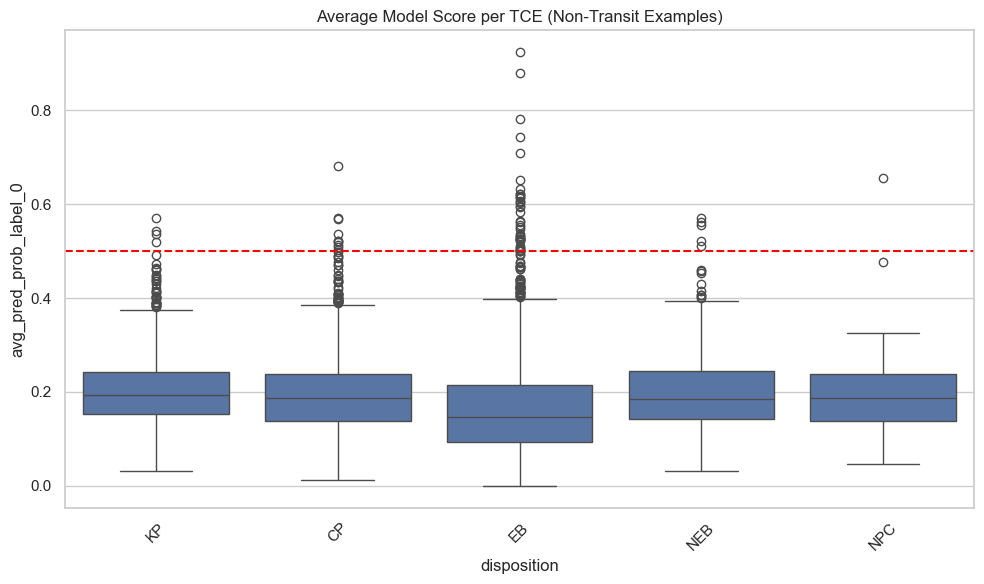

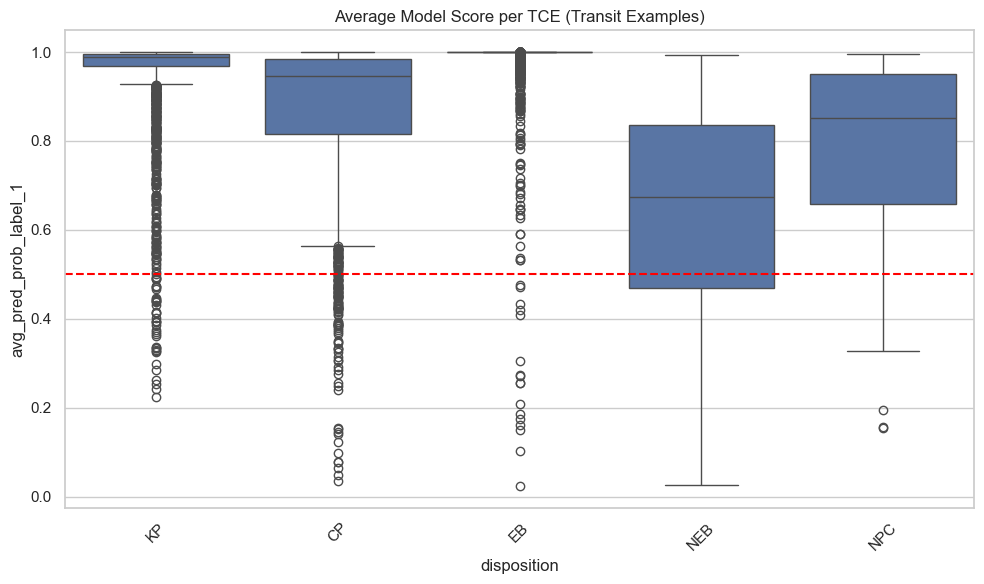

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, average_precision_score

label_key = 'tw_flag'  # your true label column
tce_key = 'tce_uid'    # your TCE identifier column

# === 1. Metrics at the example level ===
y_true = all_preds_tbl[label_key]
y_score = all_preds_tbl['pred_prob']
y_pred = all_preds_tbl['pred_label']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
prauc = average_precision_score(y_true, y_score)

print("=== All Examples ===")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

print("\n=== Disposition-Level Metrics (All Examples) ===")
for disp, group in all_preds_tbl.groupby('disposition'):
    y_true = group[label_key]
    y_score = group['pred_prob']
    y_pred = group['pred_label']

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_score)

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 2. Metrics by data split (train/val/test) at example level ===
for split in ['train', 'val', 'test']:
    split_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    y_true = split_preds_tbl[label_key]
    y_score = split_preds_tbl['pred_prob']
    y_pred = split_preds_tbl['pred_label']

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_score)

    print(f"\n=== All {split} Examples ===")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"PRAUC:     {prauc:.3f}")

    print(f"\n=== Disposition-Level Metrics (All {split} Examples) ===")
    for disp, group in split_preds_tbl.groupby('disposition'):
        y_true = group[label_key]
        y_score = group['pred_prob']
        y_pred = group['pred_label']

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        prauc = average_precision_score(y_true, y_score)

        print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 3. Compute TCE-level averages of pred_prob by label (0 and 1) ===
tce_avg = (
    all_preds_tbl
    .groupby([tce_key, label_key])['pred_prob']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={0: 'avg_pred_prob_label_0', 1: 'avg_pred_prob_label_1'})
    .reset_index()
)

# === 4. Merge disposition per TCE (disposition assumed constant per TCE) ===
tce_dispositions = (
    all_preds_tbl[[tce_key, 'disposition']]
    .drop_duplicates(subset=tce_key)
)
tce_avg = tce_avg.merge(tce_dispositions, on=tce_key, how='left')

# === 5. Compute TCE-level predicted labels by thresholding averages ===
tce_avg['pred_label_0'] = (tce_avg['avg_pred_prob_label_0'] > 0.5).astype(int)
tce_avg['pred_label_1'] = (tce_avg['avg_pred_prob_label_1'] > 0.5).astype(int)

# === 6. Metrics at TCE level separately for label=0 and label=1 ===
print("\n=== TCE-Level Metrics for Label 0 (Non-Transit Examples) ===")
label0_df = tce_avg[['tce_uid', 'avg_pred_prob_label_0', 'pred_label_0', 'disposition']].dropna(subset=['avg_pred_prob_label_0']).copy()
label0_df['true_label'] = 0  # fixed ground truth for this subset

precision = precision_score(label0_df['true_label'], label0_df['pred_label_0'], zero_division=0)
recall = recall_score(label0_df['true_label'], label0_df['pred_label_0'], zero_division=0)
prauc = average_precision_score(label0_df['true_label'], label0_df['avg_pred_prob_label_0'])

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

print("\n=== TCE-Level Metrics for Label 1 (Transit Examples) ===")
label1_df = tce_avg[['tce_uid', 'avg_pred_prob_label_1', 'pred_label_1', 'disposition']].dropna(subset=['avg_pred_prob_label_1']).copy()
label1_df['true_label'] = 1  # fixed ground truth for this subset

precision = precision_score(label1_df['true_label'], label1_df['pred_label_1'], zero_division=0)
recall = recall_score(label1_df['true_label'], label1_df['pred_label_1'], zero_division=0)
prauc = average_precision_score(label1_df['true_label'], label1_df['avg_pred_prob_label_1'])

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

# === 7. TCE-level metrics by disposition per label ===
print("\n=== TCE-Level Metrics by Disposition for Label 0 ===")
for disp, group in label0_df.groupby('disposition'):
    precision = precision_score(group['true_label'], group['pred_label_0'], zero_division=0)
    recall = recall_score(group['true_label'], group['pred_label_0'], zero_division=0)
    prauc = average_precision_score(group['true_label'], group['avg_pred_prob_label_0'])

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

print("\n=== TCE-Level Metrics by Disposition for Label 1 ===")
for disp, group in label1_df.groupby('disposition'):
    precision = precision_score(group['true_label'], group['pred_label_1'], zero_division=0)
    recall = recall_score(group['true_label'], group['pred_label_1'], zero_division=0)
    prauc = average_precision_score(group['true_label'], group['avg_pred_prob_label_1'])

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 8. Visualization ===

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=tce_avg,
    x='disposition',
    y='avg_pred_prob_label_0'
)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Non-Transit Examples)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=tce_avg,
    x='disposition',
    y='avg_pred_prob_label_1'
)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Transit Examples)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, average_precision_score

# label_key = 'tw_flag'
# tce_key = 'tce_uid'

# # === Utility Functions ===
# def compute_metrics(df, label_key, score_key, pred_key):
#     y_true = df[label_key]
#     y_score = df[score_key]
#     y_pred = df[pred_key]
#     return {
#         'Precision': precision_score(y_true, y_pred, zero_division=0),
#         'Recall': recall_score(y_true, y_pred, zero_division=0),
#         'PRAUC': average_precision_score(y_true, y_score)
#     }

# def summarize_by_disposition(df, label_key, score_key, pred_key):
#     metrics = []
#     for disp, group in df.groupby('disposition'):
#         met = compute_metrics(group, label_key, score_key, pred_key)
#         met['disposition'] = disp
#         metrics.append(met)
#     return pd.DataFrame(metrics).set_index('disposition')

# def print_metrics(title, metrics_dict):
#     print(title)
#     s = pd.Series(metrics_dict)
#     print(s.round(3))
#     print()

# def print_disp_metrics(title, metrics_df):
#     print(title)
#     print(metrics_df.round(3))
#     print()

# def plot_disp_metrics(metrics_df, title):
#     metrics_melted = metrics_df.reset_index().melt(id_vars='disposition', var_name='Metric', value_name='Value')
#     plt.figure(figsize=(8, 4))
#     sns.barplot(data=metrics_melted, x='disposition', y='Value', hue='Metric')
#     plt.title(title)
#     plt.ylim(0, 1)
#     plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.show()


# # === 1. Overall example-level metrics ===
# overall_metrics = compute_metrics(all_preds_tbl, label_key, 'pred_prob', 'pred_label')
# print_metrics("=== All Examples ===", overall_metrics)

# # === 2. Disposition-level metrics for all examples ===
# disp_metrics_all = summarize_by_disposition(preds_tbl, label_key, 'pred_prob', 'pred_label')
# print_disp_metrics("=== Disposition-Level Metrics (All Examples) ===", disp_metrics_all)
# plot_disp_metrics(disp_metrics_all, "Disposition-Level Metrics (All Examples)")

# # === 3. Metrics by data split (train/val/test) at example-level and disposition-level ===
# for split in ['train', 'val', 'test']:
#     split_df = preds_tbl[all_preds_tbl['split'] == split].copy()

#     overall_split_metrics = compute_metrics(split_df, label_key, 'pred_prob', 'pred_label')
#     print_metrics(f"=== All {split} Examples ===", overall_split_metrics)

#     disp_split_metrics = summarize_by_disposition(split_df, label_key, 'pred_prob', 'pred_label')
#     print_disp_metrics(f"=== Disposition-Level Metrics (All {split} Examples) ===", disp_split_metrics)
#     plot_disp_metrics(disp_split_metrics, f"Disposition-Level Metrics ({split.capitalize()} Examples)")

# # === 4. TCE-Level Evaluation (using majority label per TCE) ===

# # Aggregate avg predicted scores per TCE
# tce_avg_scores = (
#     all_preds_tbl
#     .groupby(tce_key)['pred_prob']
#     .mean()
#     .reset_index()
#     .rename(columns={'pred_prob': 'avg_pred_prob'})
# )

# # Get majority label per TCE
# tce_majority_label = (
#     all_preds_tbl
#     .groupby(tce_key)[label_key]
#     .agg(lambda x: int(np.round(x.mean())))
#     .reset_index()
#     .rename(columns={label_key: 'tce_majority_label'})
# )

# # Get one disposition per TCE
# tce_dispositions = (
#     all_preds_tbl[[tce_key, 'disposition']]
#     .drop_duplicates(subset=tce_key)
# )

# # Merge into final TCE-level evaluation table
# tce_eval = tce_avg_scores.merge(tce_majority_label, on=tce_key, how='left')
# tce_eval = tce_eval.merge(tce_dispositions, on=tce_key, how='left')

# # Compute TCE-level predictions
# tce_eval['tce_pred_label'] = (tce_eval['avg_pred_prob'] > 0.5).astype(int)

# # Evaluate overall TCE-level metrics
# tce_metrics_overall = compute_metrics(
#     tce_eval, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label'
# )
# print_metrics("\n=== TCE-Level Metrics (Majority Label, Avg Score) ===", tce_metrics_overall)

# # Evaluate TCE-level metrics by disposition
# tce_disp_metrics = []
# for disp, group in tce_eval.groupby('disposition'):
#     met = compute_metrics(
#         group, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label'
#     )
#     met['disposition'] = disp
#     tce_disp_metrics.append(met)

# tce_disp_metrics_df = pd.DataFrame(tce_disp_metrics).set_index('disposition')
# print_disp_metrics("=== TCE-Level Metrics by Disposition ===", tce_disp_metrics_df)
# plot_disp_metrics(tce_disp_metrics_df, "TCE-Level Metrics by Disposition")



# # === 5. Stratified sampling: limit max examples per TCE ===
# MAX_EXAMPLES_PER_TCE = 10  # adjust cap here

# np.random.seed(42)
# stratified_tbl = all_preds_tbl.groupby(tce_key).apply(
#     lambda g: g.sample(min(len(g), MAX_EXAMPLES_PER_TCE))
# ).reset_index(drop=True)

# print(f"\n=== Stratified Example-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} Examples per TCE) ===")
# strat_metrics = compute_metrics(stratified_tbl, label_key, 'pred_prob', 'pred_label')
# print_metrics("Stratified - Overall Examples", strat_metrics)

# # Disposition-level metrics on stratified sample
# strat_disp_metrics = summarize_by_disposition(stratified_tbl, label_key, 'pred_prob', 'pred_label')
# print_disp_metrics(f"Stratified - Disposition-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} per TCE)", strat_disp_metrics)
# plot_disp_metrics(strat_disp_metrics, f"Stratified Disposition-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} per TCE)")


=== All Examples (Full Data) ===
Precision    0.966
Recall       0.764
PRAUC        0.973
dtype: float64

=== Stratified Example-Level Metrics (Max 10 per TCE) ===
Precision    0.965
Recall       0.927
PRAUC        0.990
dtype: float64

=== Disposition-Level Metrics (Stratified, Max 10 per TCE) ===
             Precision  Recall  PRAUC
disposition                          
CP               0.955   0.898  0.982
EB               0.971   0.995  0.999
KP               0.962   0.967  0.995
NEB              0.967   0.631  0.964
NPC              0.953   0.764  0.963



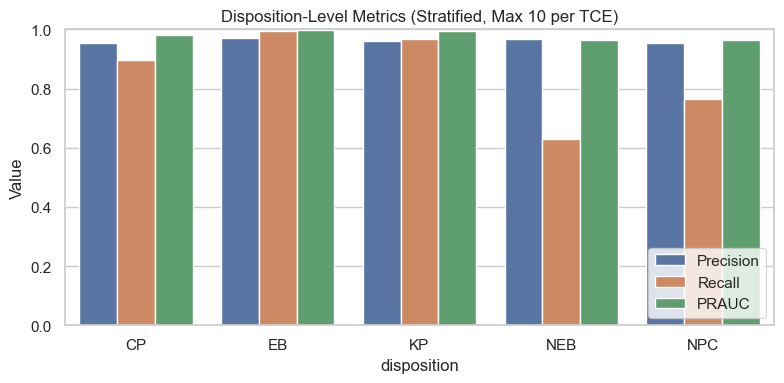

=== Disposition-Level Metrics (All Examples) ===
             Precision  Recall  PRAUC
disposition                          
CP               0.952   0.703  0.955
EB               0.977   0.995  0.999
KP               0.962   0.928  0.989
NEB              0.973   0.441  0.962
NPC              0.952   0.684  0.952



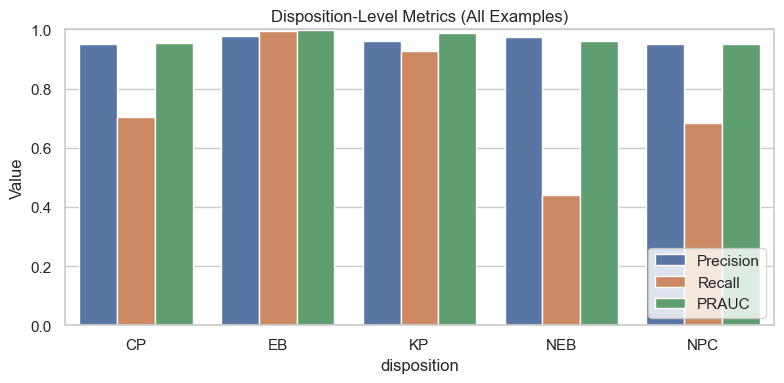

=== All train Examples ===
Precision    0.965
Recall       0.758
PRAUC        0.971
dtype: float64

=== Disposition-Level Metrics (All train Examples) ===
             Precision  Recall  PRAUC
disposition                          
CP               0.942   0.722  0.951
EB               0.977   0.995  0.999
KP               0.963   0.923  0.988
NEB              0.976   0.435  0.965
NPC              0.975   0.657  0.962



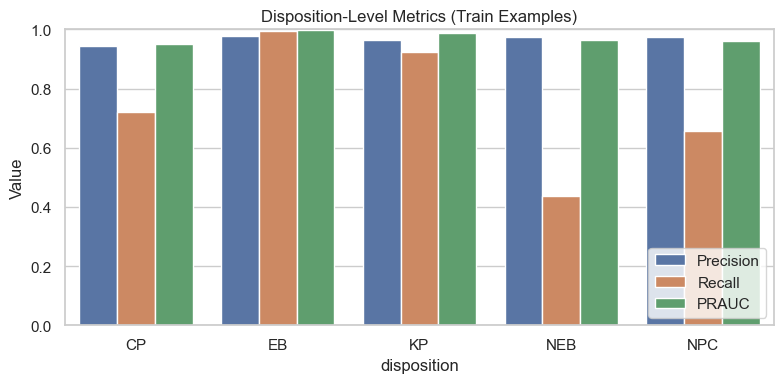

=== All val Examples ===
Precision    0.959
Recall       0.928
PRAUC        0.989
dtype: float64

=== Disposition-Level Metrics (All val Examples) ===
             Precision  Recall  PRAUC
disposition                          
CP               0.961   0.893  0.980
EB               0.977   0.995  0.999
KP               0.948   0.960  0.993
NEB              0.899   0.615  0.910
NPC              0.880   0.781  0.938



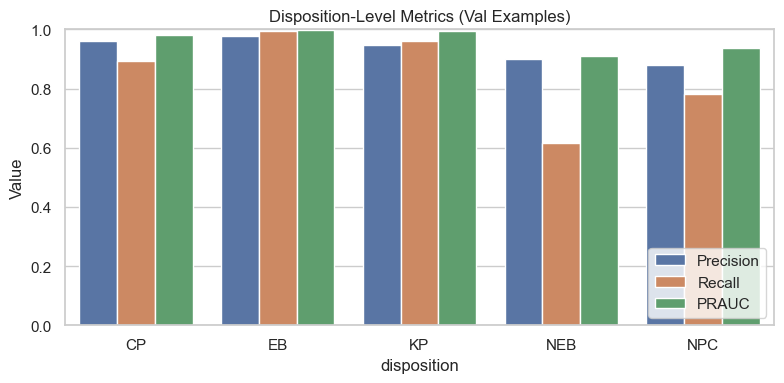

=== All test Examples ===
Precision    0.978
Recall       0.733
PRAUC        0.979
dtype: float64

=== Disposition-Level Metrics (All test Examples) ===
             Precision  Recall  PRAUC
disposition                          
CP               0.990   0.598  0.984
EB               0.975   0.996  0.999
KP               0.964   0.948  0.992
NEB              0.949   0.528  0.945
NPC              0.966   0.699  0.961



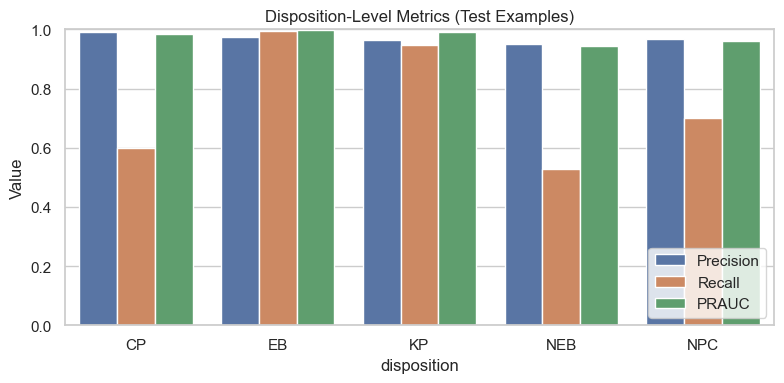


=== TCE-level Metrics (Majority Label, Avg Score) ===
Precision    0.772
Recall       0.963
PRAUC        0.986
dtype: float64

=== TCE-level Metrics by Disposition ===
             Precision  Recall  PRAUC
disposition                          
CP               0.431   0.928  0.901
EB               0.989   0.997  1.000
KP               0.376   0.984  0.982
NEB              0.668   0.584  0.800
NPC              0.441   0.743  0.791



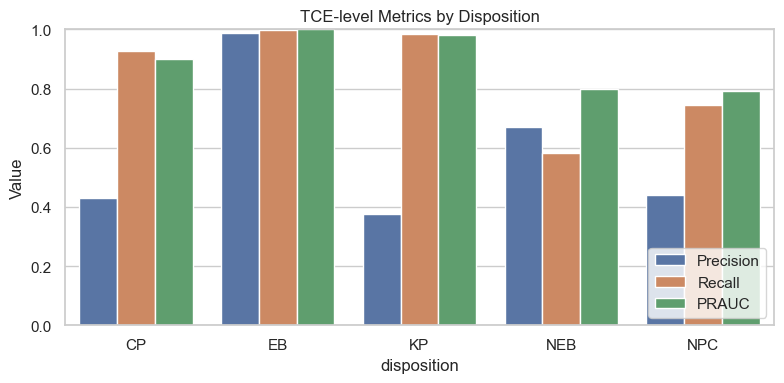


=== TCE-Level Metrics for Label 0 (Non-Transit) ===
Precision: 0.000
Recall:    0.000
PRAUC:     -0.000

=== TCE-Level Metrics for Label 1 (Transit) ===
Precision: 1.000
Recall:    0.962
PRAUC:     1.000

=== TCE-Level Metrics by Disposition for Label 0 ===
[CP] Precision: 0.000, Recall: 0.000, PRAUC: -0.000
[EB] Precision: 0.000, Recall: 0.000, PRAUC: -0.000
[KP] Precision: 0.000, Recall: 0.000, PRAUC: -0.000
[NEB] Precision: 0.000, Recall: 0.000, PRAUC: -0.000
[NPC] Precision: 0.000, Recall: 0.000, PRAUC: -0.000

=== TCE-Level Metrics by Disposition for Label 1 ===
[CP] Precision: 1.000, Recall: 0.946, PRAUC: 1.000
[EB] Precision: 1.000, Recall: 0.997, PRAUC: 1.000
[KP] Precision: 1.000, Recall: 0.978, PRAUC: 1.000
[NEB] Precision: 1.000, Recall: 0.705, PRAUC: 1.000
[NPC] Precision: 1.000, Recall: 0.880, PRAUC: 1.000


/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/jochoa4/opt/anaconda3/envs/exoplnt_dl/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y

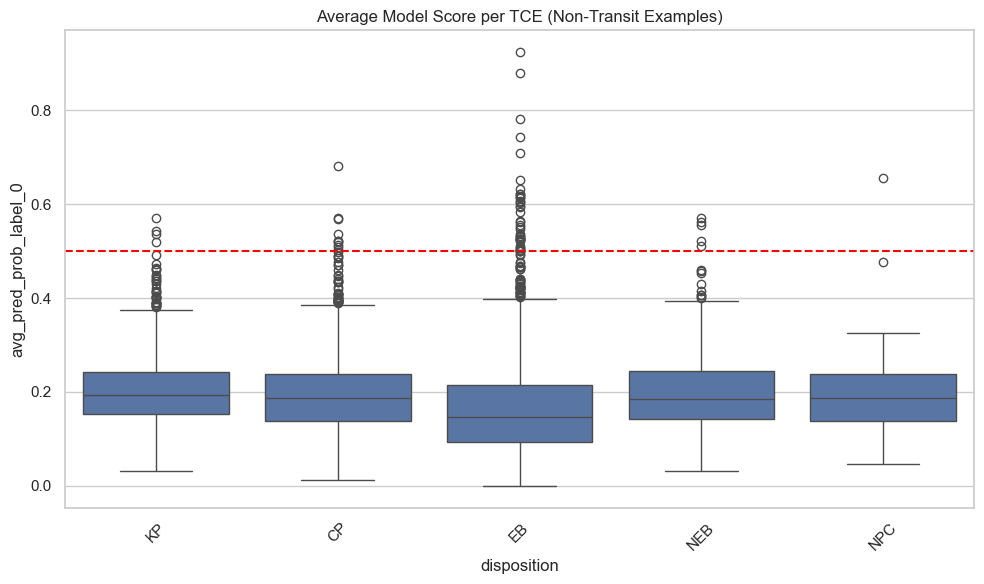

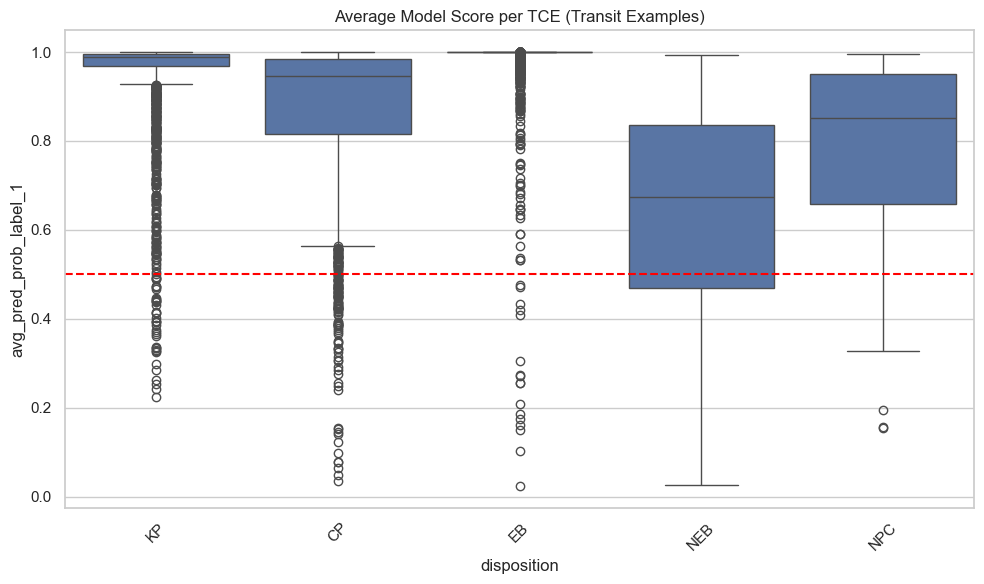

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, average_precision_score

label_key = 'tw_flag'
tce_key = 'tce_uid'

# === Utility Functions ===
def compute_metrics(df, label_key, score_key, pred_key):
    y_true = df[label_key]
    y_score = df[score_key]
    y_pred = df[pred_key]
    return {
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'PRAUC': average_precision_score(y_true, y_score)
    }

def summarize_by_disposition(df, label_key, score_key, pred_key):
    metrics = []
    for disp, group in df.groupby('disposition'):
        met = compute_metrics(group, label_key, score_key, pred_key)
        met['disposition'] = disp
        metrics.append(met)
    return pd.DataFrame(metrics).set_index('disposition')

def print_metrics(title, metrics_dict):
    print(title)
    s = pd.Series(metrics_dict)
    print(s.round(3))
    print()

def print_disp_metrics(title, metrics_df):
    print(title)
    print(metrics_df.round(3))
    print()

def plot_disp_metrics(metrics_df, title):
    metrics_melted = metrics_df.reset_index().melt(id_vars='disposition', var_name='Metric', value_name='Value')
    plt.figure(figsize=(8, 4))
    sns.barplot(data=metrics_melted, x='disposition', y='Value', hue='Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# === Stratified sampling function to cap max examples per TCE ===
def stratified_sample(df, tce_key, max_per_tce):
    def cap_group(group):
        if len(group) > max_per_tce:
            return group.sample(max_per_tce, random_state=42)
        else:
            return group
    sampled_df = df.groupby(tce_key).apply(cap_group).reset_index(drop=True)
    return sampled_df

# === 1. Overall example-level metrics (full data) ===
overall_metrics = compute_metrics(all_preds_tbl, label_key, 'pred_prob', 'pred_label')
print_metrics("=== All Examples (Full Data) ===", overall_metrics)

# === 1b. Stratified capped example-level metrics ===
max_examples_per_tce = 10  # set your cap here
stratified_df = stratified_sample(all_preds_tbl, tce_key, max_examples_per_tce)

strat_metrics = compute_metrics(stratified_df, label_key, 'pred_prob', 'pred_label')
print_metrics(f"=== Stratified Example-Level Metrics (Max {max_examples_per_tce} per TCE) ===", strat_metrics)

# Disposition-level metrics on stratified data
disp_metrics_strat = summarize_by_disposition(stratified_df, label_key, 'pred_prob', 'pred_label')
print_disp_metrics(f"=== Disposition-Level Metrics (Stratified, Max {max_examples_per_tce} per TCE) ===", disp_metrics_strat)
plot_disp_metrics(disp_metrics_strat, f"Disposition-Level Metrics (Stratified, Max {max_examples_per_tce} per TCE)")

# === 2. Disposition-level metrics for all examples (full data) ===
disp_metrics_all = summarize_by_disposition(all_preds_tbl, label_key, 'pred_prob', 'pred_label')
print_disp_metrics("=== Disposition-Level Metrics (All Examples) ===", disp_metrics_all)
plot_disp_metrics(disp_metrics_all, "Disposition-Level Metrics (All Examples)")

# === 3. Metrics by data split (train/val/test) at example-level and disposition-level ===
for split in ['train', 'val', 'test']:
    split_df = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    overall_split_metrics = compute_metrics(split_df, label_key, 'pred_prob', 'pred_label')
    print_metrics(f"=== All {split} Examples ===", overall_split_metrics)

    disp_split_metrics = summarize_by_disposition(split_df, label_key, 'pred_prob', 'pred_label')
    print_disp_metrics(f"=== Disposition-Level Metrics (All {split} Examples) ===", disp_split_metrics)
    plot_disp_metrics(disp_split_metrics, f"Disposition-Level Metrics ({split.capitalize()} Examples)")

# === 4. Aggregate predictions and majority label at TCE level ===
tce_avg_all = (
    all_preds_tbl
    .groupby(tce_key)['pred_prob']
    .mean()
    .reset_index()
    .rename(columns={'pred_prob': 'avg_pred_prob'})
)

tce_majority_label = (
    all_preds_tbl
    .groupby(tce_key)[label_key]
    .agg(lambda x: int(np.round(x.mean())))
    .reset_index()
    .rename(columns={label_key: 'tce_majority_label'})
)

tce_dispositions = (
    all_preds_tbl[[tce_key, 'disposition']]
    .drop_duplicates(subset=tce_key)
)

tce_eval = tce_avg_all.merge(tce_majority_label, on=tce_key, how='left')
tce_eval = tce_eval.merge(tce_dispositions, on=tce_key, how='left')

tce_eval['tce_pred_label'] = (tce_eval['avg_pred_prob'] > 0.5).astype(int)

tce_metrics_overall = compute_metrics(tce_eval, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label')
print_metrics("\n=== TCE-level Metrics (Majority Label, Avg Score) ===", tce_metrics_overall)

tce_disp_metrics = []
for disp, group in tce_eval.groupby('disposition'):
    met = compute_metrics(group, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label')
    met['disposition'] = disp
    tce_disp_metrics.append(met)
tce_disp_metrics_df = pd.DataFrame(tce_disp_metrics).set_index('disposition')
print_disp_metrics("=== TCE-level Metrics by Disposition ===", tce_disp_metrics_df)
plot_disp_metrics(tce_disp_metrics_df, "TCE-level Metrics by Disposition")

# === 5. Compute TCE-level avg pred_prob by label separately (0 and 1) ===
tce_avg_labels = (
    all_preds_tbl
    .groupby([tce_key, label_key])['pred_prob']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={0: 'avg_pred_prob_label_0', 1: 'avg_pred_prob_label_1'})
    .reset_index()
)

tce_avg_labels = tce_avg_labels.merge(tce_dispositions, on=tce_key, how='left')

# Compute predicted labels for each label's avg score thresholded at 0.5
tce_avg_labels['pred_label_0'] = (tce_avg_labels['avg_pred_prob_label_0'] > 0.5).astype(int)
tce_avg_labels['pred_label_1'] = (tce_avg_labels['avg_pred_prob_label_1'] > 0.5).astype(int)

# Metrics for Label 0 (Non-transit)
print("\n=== TCE-Level Metrics for Label 0 (Non-Transit) ===")
label0_df = tce_avg_labels.dropna(subset=['avg_pred_prob_label_0']).copy()
label0_df['true_label'] = 0

precision = precision_score(label0_df['true_label'], label0_df['pred_label_0'], zero_division=0)
recall = recall_score(label0_df['true_label'], label0_df['pred_label_0'], zero_division=0)
prauc = average_precision_score(label0_df['true_label'], label0_df['avg_pred_prob_label_0'])

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

print("\n=== TCE-Level Metrics for Label 1 (Transit) ===")
label1_df = tce_avg_labels.dropna(subset=['avg_pred_prob_label_1']).copy()
label1_df['true_label'] = 1

precision = precision_score(label1_df['true_label'], label1_df['pred_label_1'], zero_division=0)
recall = recall_score(label1_df['true_label'], label1_df['pred_label_1'], zero_division=0)
prauc = average_precision_score(label1_df['true_label'], label1_df['avg_pred_prob_label_1'])

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

# TCE-level metrics by disposition for label 0
print("\n=== TCE-Level Metrics by Disposition for Label 0 ===")
for disp, group in label0_df.groupby('disposition'):
    precision = precision_score(group['true_label'], group['pred_label_0'], zero_division=0)
    recall = recall_score(group['true_label'], group['pred_label_0'], zero_division=0)
    prauc = average_precision_score(group['true_label'], group['avg_pred_prob_label_0'])
    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# TCE-level metrics by disposition for label 1
print("\n=== TCE-Level Metrics by Disposition for Label 1 ===")
for disp, group in label1_df.groupby('disposition'):
    precision = precision_score(group['true_label'], group['pred_label_1'], zero_division=0)
    recall = recall_score(group['true_label'], group['pred_label_1'], zero_division=0)
    prauc = average_precision_score(group['true_label'], group['avg_pred_prob_label_1'])
    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 6. Visualization of avg model score per TCE for each label ===
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=tce_avg_labels, x='disposition', y='avg_pred_prob_label_0')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Non-Transit Examples)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=tce_avg_labels, x='disposition', y='avg_pred_prob_label_1')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Transit Examples)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, average_precision_score

label_key = 'tw_flag'
tce_key = 'tce_uid'

# === 1. Metrics at the example level ===
y_true = all_preds_tbl[label_key]
y_score = all_preds_tbl['pred_prob']
y_pred = all_preds_tbl['pred_label']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
prauc = average_precision_score(y_true, y_score)

print("=== All Examples ===")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"PRAUC:     {prauc:.3f}")

print("\n=== Disposition-Level Metrics (All Examples) ===")
for disp, group in all_preds_tbl.groupby('disposition'):
    y_true = group[label_key]
    y_score = group['pred_prob']
    y_pred = group['pred_label']

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_score)

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 2. Metrics by data split (train/val/test) at example level ===
for split in ['train', 'val', 'test']:
    split_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    y_true = split_preds_tbl[label_key]
    y_score = split_preds_tbl['pred_prob']
    y_pred = split_preds_tbl['pred_label']

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_score)

    print(f"\n=== All {split} Examples ===")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"PRAUC:     {prauc:.3f}")

    print(f"\n=== Disposition-Level Metrics (All {split} Examples) ===")
    for disp, group in split_preds_tbl.groupby('disposition'):
        y_true = group[label_key]
        y_score = group['pred_prob']
        y_pred = group['pred_label']

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        prauc = average_precision_score(y_true, y_score)

        print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")

# === 3. Aggregate all examples per TCE: average pred_prob ===
tce_avg_all = (
    all_preds_tbl
    .groupby(tce_key)['pred_prob']
    .mean()
    .reset_index()
    .rename(columns={'pred_prob': 'avg_pred_prob'})
)

# === 4. Get TCE-level true label: max label within TCE ===
tce_true_label = (
    all_preds_tbl
    .groupby(tce_key)[label_key]
    .max()
    .reset_index()
    .rename(columns={label_key: 'tce_true_label'})
)

# === 5. Merge disposition (constant per TCE) ===
tce_dispositions = (
    all_preds_tbl[[tce_key, 'disposition']]
    .drop_duplicates(subset=tce_key)
)
tce_eval = tce_avg_all.merge(tce_true_label, on=tce_key, how='left')
tce_eval = tce_eval.merge(tce_dispositions, on=tce_key, how='left')

# === 6. Compute TCE-level predictions ===
y_true = tce_eval['tce_true_label']
y_score = tce_eval['avg_pred_prob']
y_pred = (y_score > 0.5).astype(int)

print("\n=== TCE-level Metrics (all examples average) ===")
print(f"Precision: {precision_score(y_true, y_pred):.3f}")
print(f"Recall:    {recall_score(y_true, y_pred):.3f}")
print(f"PRAUC:     {average_precision_score(y_true, y_score):.3f}")

print("\n=== TCE-level Metrics by Disposition ===")
for disp, group in tce_eval.groupby('disposition'):
    y_true = group['tce_true_label']
    y_score = group['avg_pred_prob']
    y_pred = (y_score > 0.5).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    prauc = average_precision_score(y_true, y_score)

    print(f"[{disp}] Precision: {precision:.3f}, Recall: {recall:.3f}, PRAUC: {prauc:.3f}")


In [ ]:
import seaborn as sns
sns.boxplot(data=all_preds_tbl[all_preds_tbl[label_key] == 0], x='disposition', y='pred_prob')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Model Scores for Non-Transit Examples (by Disposition)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.boxplot(data=all_preds_tbl[all_preds_tbl[label_key] == 1], x='disposition', y='pred_prob')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Model Scores for Transit Examples (by Disposition)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# tce_avg = all_preds_tbl.groupby(['tce_id', label_key])['pred_prob'].mean().unstack()

tce_avg = (
    all_preds_tbl
    .groupby(['tce_uid', label_key])['pred_prob']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={0: 'avg_pred_prob_label_0', 1: 'avg_pred_prob_label_1'})
    .reset_index()
)

# 2. Get disposition per tce_id (disposition is constant within tce)
tce_dispositions = (
    all_preds_tbl[['tce_uid', 'disposition']]
    .drop_duplicates(subset='tce_uid')
)

# 3. Merge disposition into tce_avg
tce_avg = tce_avg.merge(tce_dispositions, on='tce_uid', how='left')

# 4. Plot: only negative label averages
sns.boxplot(
    data=tce_avg,
    x='disposition',
    y='avg_pred_prob_label_0'
)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Non-Transit Examples)")
plt.xticks(rotation=45)
plt.show()

# 5. Plot: only positive label averages
sns.boxplot(
    data=tce_avg,
    x='disposition',
    y='avg_pred_prob_label_1'
)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Transit Examples)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# tce_avg = all_preds_tbl.groupby(['tce_id', label_key])['pred_prob'].mean().unstack()

tce_avg = (
    all_preds_tbl
    .groupby(['tce_uid', label_key])['pred_prob']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={0: 'avg_pred_prob_label_0', 1: 'avg_pred_prob_label_1'})
    .reset_index()
)

# 2. Get disposition per tce_id (disposition is constant within tce)
tce_dispositions = (
    all_preds_tbl[['tce_uid', 'disposition']]
    .drop_duplicates(subset='tce_uid')
)

# 3. Merge disposition into tce_avg
tce_avg = tce_avg.merge(tce_dispositions, on='tce_uid', how='left')

# 4. Plot: only negative label averages
sns.boxplot(
    data=tce_avg,
    x='disposition',
    y='avg_pred_prob_label_0'
)
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Average Model Score per TCE (Negative Label)")
plt.xticks(rotation=45)
plt.show()

## Metrics

## TCE Avg Metrics

### DEPRECATED BELOW


In [ ]:
train_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == 'train']
train_preds_tbl[(train_preds_tbl['tce_dikco_msky'] > 20.0)]['tce_uid']

In [ ]:
for col in tce_tbl.columns:
    if 'FP' in list(tce_tbl[col]):
        print(f'col: {col}')


In [ ]:
for col in tce_tbl.columns:
    if 'dikco' in col:
        print(col)

In [ ]:
abs(all_preds_tbl['pred_prob'] - all_preds_tbl['label'])

In [ ]:
all_preds_tbl['tce_dikco_msky_err_original'].describe()

In [ ]:
all_preds_tbl['pred_err'] = all_preds_tbl.apply(lambda r: abs(r['pred_prob'] - r['label']), axis=1)
all_preds_tbl['ratio'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] / (r['tce_dikco_msky_original'] + 1e-8), axis=1)
all_preds_tbl['err_cap'] = all_preds_tbl.apply(lambda r: 0.33 * (r['tce_dikco_msky_original'] ), axis=1)
all_preds_tbl['tic_offset_estimate'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] + (r['tce_dikco_msky_original']), axis=1)
all_preds_tbl['uncer_err'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] / (abs(r['tce_dikco_msky_err_original'] + r['tce_dikco_msky_original'])), axis=1)
eb_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'EB']
eb_preds['pred_err'].describe()
cp_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'CP']
cp_preds['pred_err'].describe()

In [ ]:
ratio_preds = eb_preds[(eb_preds['ratio'] <  0.25) & (eb_preds['split'] == 'train')]
ratio_preds['confusion'].value_counts()

In [ ]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] > 0)]
print(filt_eb_preds['confusion'].value_counts())

In [ ]:
filt_cp_preds = cp_preds[((cp_preds['tce_dikco_msky_original'] + cp_preds['tce_dikco_msky_err_original']) < 20) & (cp_preds['tce_dikco_msky_err_original'] >= 0) ]
print(filt_cp_preds['confusion'].value_counts())

In [ ]:
cp_preds['confusion'].value_counts()

In [ ]:
filt_eb_preds = eb_preds[((eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) < 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0) ]
print(filt_eb_preds['confusion'].value_counts())

In [ ]:
eb_preds[((eb_preds['tce_dikco_msky_original'] < 4.2) & ( (eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) < 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0)) ]['confusion'].value_counts()


In [ ]:
bad_eb_examples = eb_preds[(( (eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) >= 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0)) ]
bad_eb_examples['confusion'].value_counts()


In [ ]:
bad_eb_examples[bad_eb_examples['confusion'] == 'FN']['target_id'].value_counts()

In [ ]:
offset_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_dikco_msky_original', 'tce_dikco_msky_err_original', 'tce_dicco_msky_original', 'tce_dicco_msky_err_original']
tce_tbl[tce_tbl['target_id'] == 420114776][offset_cols]

In [ ]:
tce_tbl[tce_tbl['disposition'] == 'EB']['tce_dikco_msky_err_original'].describe()

In [ ]:
filt_eb_preds[(filt_eb_preds['tce_dikco_msky_original'] < 5.6)]['confusion'].value_counts()

In [ ]:
filt_eb_preds[((filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original']) < 4.2)]['confusion'].value_counts()

In [ ]:
filt_eb_preds[((filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original']) < 4.2)]['confusion'].value_counts()

In [ ]:
eb_preds['confusion'].value_counts()

In [ ]:
test = filt_eb_preds[(filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original'] < (4.2 ))]
test['confusion'].value_counts()

In [ ]:
filt_eb_preds[filt_eb_preds['confusion'] == 'FN']['target_id'].value_counts()

In [ ]:
test[test['confusion'] == 'FN']['target_id'].value_counts()

In [ ]:
test[test['target_id'] == 193831684]

In [ ]:
eb_preds[(eb_preds['tce_dikco_msky_original'] / eb_preds['tce_dikco_msky_err_original'] > 0)]['confusion'].value_counts()

In [ ]:
filt_eb_preds = eb_preds[
    (eb_preds['tce_dikco_msky_original'] < 4.2) &
    (eb_preds['tce_dikco_msky_err_original'] + eb_preds['tce_dikco_msky_original'] < (5.6))
]

print(filt_eb_preds['confusion'].value_counts())
print((filt_eb_preds['tce_dikco_msky_err_original'] > 0).sum())
print((filt_eb_preds['tce_dikco_msky_err_original'] <= 0).sum())

In [ ]:
(eb_preds['tce_dikco_msky_original'] < 0).sum()

In [ ]:
eb_preds[eb_preds['tce_dikco_msky_err_original'] > eb_preds['tce_dikco_msky_original']]['confusion'].value_counts()

In [ ]:
cp_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'CP']
cp_preds['confusion'].value_counts()

In [ ]:
(cp_preds['ratio'] < 1/3).sum()

In [ ]:
thr_cp_preds = cp_preds[cp_preds['tce_dikco_msky_original'] < 4.2]
thr_cp_preds['confusion'].value_counts()

In [ ]:
thr_eb_preds = eb_preds[eb_preds['tce_dikco_msky_original'] < 4.2]
thr_eb_preds['confusion'].value_counts()

In [ ]:
thr_eb_preds[thr_eb_preds['tce_dikco_msky_err_original'] <= -1.0]['confusion'].value_counts()

In [ ]:
print(((eb_preds['label'] == 1)
       &
       (eb_preds['tce_dikco_msky_err_original'] >= 0)).sum())

In [ ]:
print((eb_preds['tce_dikco_msky_original'] < 0).sum())
print((eb_preds['tce_dikco_msky_err_original'] < 0).sum())

In [ ]:
print((eb_preds['tce_dikco_msky_original'] >= 0).sum())
print((eb_preds['tce_dikco_msky_err_original'] >= 0).sum())

In [ ]:
ratio_preds[ratio_preds['tce_dikco_msky_original'] < 4.2]['confusion'].value_counts()

In [ ]:
uncer_preds = eb_preds[(eb_preds['ratio'] < 0.3333) & eb_preds['']]
uncer_preds['confusion'].value_counts()

In [ ]:
20944 + 207

In [ ]:
uncer_preds[uncer_preds['split'] == 'train']['confusion'].value_counts()

In [ ]:
20759 + 196

In [ ]:
20759 + 196

In [ ]:
20944 + 207

In [ ]:
20935 + 207

In [ ]:
ratio_preds[ratio_preds['split'] == 'train']['confusion'].value_counts()

In [ ]:
20361 + 207

In [ ]:
20935 + 207

In [ ]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] < eb_preds['tce_dikco_msky_err_original'])]
print(filt_eb_preds['confusion'].value_counts())

In [ ]:
filt_all_preds = all_preds_tbl[
    (all_preds_tbl['tce_dikco_msky_original'] < 4.2) &
    (all_preds_tbl['tce_dikco_msky_err_original'] < (1/3) * all_preds_tbl['tce_dikco_msky_original'])
]
print(filt_all_preds['confusion'].value_counts())

In [ ]:
filt_eb_preds = eb_preds[
    (eb_preds['tce_dikco_msky_original'] < 4.2) &
    ((eb_preds['tce_dikco_msky_err_original'] / eb_preds['tce_dikco_msky_original']) < (1/3) )
]
print(filt_eb_preds['confusion'].value_counts())

In [ ]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] > ( 0.33 * eb_preds['tce_dikco_msky_original']))]
print(filt_eb_preds['confusion'].value_counts())

In [ ]:
tce_tbl[tce_tbl['disposition'] == 'EB']['tce_dikco_msky_err_original'].describe()

In [ ]:
eb_preds[(eb_preds['tce_dicco_msky_original'] <  4.2) & (eb_preds['tce_dicco_msky_err_original'] >  0.33)]['confusion'].value_counts()

In [ ]:
eb_preds['confusion'].value_counts()

In [ ]:
all_preds_tbl['confusion'].value_counts()

In [ ]:
all_preds_tbl[(all_preds_tbl['ratio'] < 0.25)]['confusion'].value_counts()

In [ ]:
eb_preds['tce_dicco_msky_err_original'].describe()

In [ ]:
eb_preds[eb_preds['tce_dicco_msky_err_original'] == -1.0]['confusion'].value_counts()

In [ ]:
eb_preds[( ((eb_preds['tce_dikco_msky_original'] <  4.2) & (eb_preds['tce_dikco_msky_err_original'] <  (0.33 * eb_preds['tce_dikco_msky_original']))))]['confusion'].value_counts()


In [ ]:
eb_preds[( ((eb_preds['tce_dicco_msky_original'] <  4.2) & (eb_preds['tce_dicco_msky_err_original'] <  0.33 * eb_preds['offset_estimate']) ))]['confusion'].value_counts()


In [ ]:
all_preds_tbl[( ((all_preds_tbl['tce_dicco_msky_original'] >  4.2) & (all_preds_tbl['tce_dicco_msky_err_original'] >  0.33) & (all_preds_tbl['tce_dicco_msky_err_original'] != -1.0)))]['confusion'].value_counts()


In [ ]:
for split in [ 'ANY']:
    print(f"\n{split} preds:")
    if split == 'ANY':
        split_preds_tbl = all_preds_tbl
    else:
        split_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split]

    for disp in ['EB']:
        print(f"\n{disp} preds:")
        disp_preds = split_preds_tbl[split_preds_tbl['disposition'] == disp]
        print(disp_preds[(disp_preds['tce_dicco_msky_original'] <  4.2) & ((disp_preds['tce_dicco_msky_err_original'] <  0.33)) ]['confusion'].value_counts())


In [ ]:
eb_preds[( (eb_preds['tce_dicco_msky_original'] >  4.2) & ((eb_preds['tce_dicco_msky_err_original'] / eb_preds['tce_dicco_msky_original']) < 0.33))]['confusion'].value_counts()


In [ ]:
eb_preds[eb_preds['tce_dicco_msky_err_original'] <  0.25]['confusion'].value_counts()

In [ ]:
eb_preds[eb_preds['ratio'] < 0.2]['confusion'].value_counts()

In [ ]:
est = eb_preds.apply(lambda r: r['tce_dikco_msky_err_original'] / abs(r['tce_dikco_msky_original'] + 1e-8), axis=1)

In [ ]:
est[est > 0.2]

In [ ]:
eb_preds[eb_preds['tce_dikco_msky_original'] > 0]['pred_err'].describe()

In [ ]:
tce_subset_df['tce_dikco_msky']

In [ ]:
for 

In [ ]:
tce_subset_df = tce_tbl[tce_tbl['tce_uid'] == '420114776-1-S24']
for col in tce_subset_df.columns:
    if pd.api.types.is_numeric_dtype(tce_subset_df[col]):
        if (tce_subset_df[col] > 20).any() and (tce_subset_df[col] < 21).any():
            print(col)

In [ ]:
tce_tbl['TFOPWG Disposition'].unique()

In [ ]:
for split, df in summary_df[summary_df['disposition'] != 'ANY'].groupby("split"):
    pivot_split = (
        df.pivot(index="disposition", columns="confusion", values="count")
          .fillna(0)
          .loc[:, ["FN","FP"]]
    )
    fig, ax = plt.subplots(figsize=(5,4))
    pivot_split.plot(kind="bar", stacked=False, ax=ax)
    ax.set_title(f"{split.capitalize()} Set")
    ax.set_xlabel("Disposition")
    ax.set_ylabel("Count")
    ax.legend(title="Outcome", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
train_preds = all_preds_tbl[all_preds_tbl['split'] == 'train']
train_preds[train_preds['disposition'] == 'KP']['label'].sum()

In [ ]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['label'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['label'].value_counts())
    false_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")
        

In [ ]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['confusion'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['confusion'].value_counts())
    false_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")
    

# Analyzing Val

In [ ]:
example_map = {}
for split_name in ['val', 'test', 'train']:
    logger.info(f"Analyzing split: {split_name}")
    df_split = all_preds_tbl[all_preds_tbl['split'] == split_name]

    # only need FN & FP
    false_examples = {
        'FP': df_split[df_split['confusion'] == 'FP'],
        'FN': df_split[df_split['confusion'] == 'FN']
    }

    example_map[split_name] = {}
    for cf, df_cf in false_examples.items():
        example_map[split_name][cf] = {}
        for t in df_cf['target_id'].unique():
            df_t = df_cf[df_cf['target_id'] == t]
            example_map[split_name][cf][t] = {}
            for tce_uid in df_t['tce_uid'].unique():
                # grab all rows for this target+TCE
                uids = df_t[df_t['tce_uid'] == tce_uid]['uid'].tolist()
                example_map[split_name][cf][t][tce_uid] = uids

        logger.info(f"{split_name} | {cf} Summary:")
        logger.info(df_cf[['pred_label','pred_prob']].describe().to_string())
        logger.info(f"{split_name} | {cf} Unique TCEs: {df_cf['tce_uid'].unique()}")
        logger.info(f"{split_name} | {cf} Unique Targets: {df_cf['target_id'].unique()}")


In [ ]:
for info in example_map['val'].items():
    print(info)

In [ ]:
nl = '   '
for split in ['train', 'test', 'val']:
    print(f"{nl * 0} {split}")
    for cf in ['FP', 'FN']:
        print(f"{nl * 1} {cf}")
        for target in example_map[split][cf]:
            print(f"{nl * 2} {target}")
            for tce_uid, examples in example_map[split][cf][target].items():
                print(f"{nl * 3} {tce_uid} : {[str(round(float(e.split('_t_')[-1]), 2)) for e in examples]}")
            

print(example_map['train']['FP'])

In [ ]:

splits = ['val', 'test', 'train']
for split in splits:
    df_split = all_preds_tbl[all_preds_tbl['split'] == split]
    for cf in ['FP','FN']:
        df_cf = df_split[df_split['confusion'] == cf]

        # 1) Compute per-(target, tce_uid) mean confidence
        tce_means = (
            df_cf
            .groupby(['target_id','tce_uid'])['pred_prob']
            .mean()
            .rename('tce_avg')
            .reset_index()
        )

        # 2) Compute per-target mean of those tce_uids
        target_means = (
            tce_means
            .groupby('target_id')['tce_avg']
            .mean()
            .rename('target_avg')
            .sort_values(ascending=False)
        )

        print(f"\n=== {split} | {cf} ===")
        for target_id, target_avg in target_means.items():
            print(f"Target {target_id:>10}  ➜  avg prob = {target_avg:.3f}")

            # pull out all the tce's for this target and sort them
            tces = (
                tce_means[tce_means['target_id'] == target_id]
                .set_index('tce_uid')['tce_avg']
                .sort_values(ascending=False)
            )

            for tce_uid, tce_avg in tces.items():
                # list all the underlying uids for context
                uids = (
                    df_cf
                    .loc[
                        (df_cf['target_id']==target_id)&
                        (df_cf['tce_uid']==tce_uid),
                        'uid'
                    ]
                    .tolist()
                )
                print(f"    TCE {tce_uid:>8}  ➜  avg prob = {tce_avg:.3f} from {len(uids)} examples ")

In [ ]:
def _summarize_tce_examples(tce_uid: str):
    interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    t_tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0]))].copy()
    logger.info(t_tce_tbl_filt[interest_cols])
    
    tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0])) & (tce_tbl['sector_run'] == tce_uid.split('S')[-1].split('_')[0])]
    logger.info(tce_tbl_filt[interest_cols])
    tce_preds_tbl = all_preds_tbl[all_preds_tbl["tce_uid"] == tce_uid].copy()
    logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
    logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Stats by Confusion Label: ")
    for cf in tce_preds_tbl['confusion'].unique():
        logger.info(f"{' ' * 4}{cf} Stats:")
        desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
        logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
    
_summarize_tce_examples("30450412-1-S12")

# Looking at average correctness by target and TCE

In [ ]:
all_preds_tbl.columns

In [ ]:
splits = ['val','test','train']
for split in splits:
    # 1) select split
    df = all_preds_tbl[all_preds_tbl['split']==split].copy()

    # 2) define correctness: if true_label==1, use pred_prob; else use 1–pred_prob
    df['correctness'] = (
        df['pred_prob'] * df['label'] +
        (1 - df['pred_prob']) * (1 - df['label'])
    )

    # 3) average up to the TCE level
    tce_corr = (
        df
        .groupby(['target_id','tce_uid'])['correctness']
        .mean()
        .rename('tce_corr')
        .reset_index()
    )

    # 4) average those TCE‐means to the target level
    target_corr = (
        tce_corr
        .groupby('target_id')['tce_corr']
        .mean()
        .rename('target_corr')
        .reset_index()
        .sort_values('target_corr', ascending=False)
    )

    # 5) display
    print(f"\n=== Split: {split} — target‐level correctness ===")
    for _, row in target_corr.iterrows():
        print(f"Target {int(row['target_id'])}  ➜  avg correctness = {row['target_corr']:.3f}")


In [ ]:
splits = ['val', 'test', 'train']
for split in splits:
    df = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    for cf in ['FP', 'FN']:
        df_wrong = df[df['confusion'] == cf]

        # Count wrong examples per TCE (target_id + tce_uid)
        tce_counts = (
            df_wrong
            .groupby(['target_id', 'tce_uid'])
            .size()
            .rename('num_wrong_examples')
            .reset_index()
        )

        # Count total wrong examples per target
        target_counts = (
            tce_counts
            .groupby('target_id')['num_wrong_examples']
            .sum()
            .rename('total_wrong_examples')
            .reset_index()
            .sort_values('total_wrong_examples', ascending=False)
        )

        # === DISPLAY per-target ===
        print(f"\n=== Split: {split} | {cf} — total wrong examples per target ===")
        for row in target_counts.itertuples(index=False):
            print(f"Target {int(row.target_id)}  ➜  total wrong = {row.total_wrong_examples}")

        # === DISPLAY per-TCE within target ===
        print(f"\n=== Split: {split} | {cf} — wrong examples per TCE ===")
        tce_counts_sorted = tce_counts.sort_values(['target_id', 'num_wrong_examples'], ascending=[True, False])
        for row in tce_counts_sorted.itertuples(index=False):
            print(f"Target {int(row.target_id)} | TCE {row.tce_uid}  ➜  wrong examples = {row.num_wrong_examples}")


In [ ]:
interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
tce_tbl[tce_tbl['target_id'] == 356473034][interest_cols]
# tce_tbl[(tce_tbl['target_id'] == 410418820) & (tce_tbl['sector_run'] == '1-36')][interest_cols]

In [ ]:
tce_tbl['disposition'].unique()

In [ ]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['confusion'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['confusion'].value_counts())
    false_examples = worst_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")

In [ ]:
logger.info(f"Train set consists of {len(preds_tbl)} examples.")
logger.info(preds_tbl['confusion'].value_counts())

for disp in preds_tbl['disposition'].unique():
    logger.info(f"{disp} Summary")
    disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
    logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
    logger.info(disp_preds_tbl['confusion'].value_counts())
worst_examples = {
    cf : defaultdict(list) for cf in preds_tbl["confusion"].unique()
}

num_examples = 200
# Get most confident FP/TN predictions
fp_df = preds_tbl[preds_tbl["confusion"] == "FP"]
worst_examples["FP"] = fp_df.nlargest(num_examples, columns=["pred_prob"])

tn_df = preds_tbl[preds_tbl["confusion"] == "TN"]
worst_examples["TN"] = tn_df.nlargest(num_examples, columns=["pred_prob"])

# Get least confident TP/FN predictions
tp_df = preds_tbl[preds_tbl["confusion"] == "TP"]
worst_examples["TP"] = tp_df.nsmallest(num_examples, columns=["pred_prob"])

fn_df = preds_tbl[preds_tbl["confusion"] == "FN"]
worst_examples["FN"] = fn_df.nsmallest(num_examples, columns=["pred_prob"])


In [ ]:


len(fn_df["target_id"].unique())
logger.info(f"{len(fn_df[fn_df['tw_flag'] < 0])}")
fn_df.describe()
fn_df["mixed"] = fn_df.apply(lambda r: 1 if int(r['target_id']) in mixed_targets else 0, axis=1)

logger.info(f"MIXED FNs: {fn_df['mixed'].sum()}/{len(fn_df)}")

fn_df.head()

In [ ]:

ex_at_mixed_target = {}
for cf, exs_df in worst_examples.items():
    exs_df["mixed_target_flag"] = exs_df.apply(lambda r: 1 if int(r['target_id']) in mixed_targets else 0, axis=1)
    # logger.info(f"{cf}: {exs_df['mixed_target_flag'].sum()} / {} are mixed")

In [ ]:
len(worst_examples["FN"]["target_id"].unique())

In [ ]:
# worst_examples["FP"]["target_id"].unique()
worst_examples["FN"][20:40]#["target_id"].unique()

In [ ]:

worst_targets_set = set([])
worst_targets_list = []
worst_targets_map = defaultdict(list)
for _, fn in worst_examples["FN"].iterrows():
    logger.info(f"{fn['target']}, {fn['uid']}, {fn['pred_prob']}")
    worst_targets_set.add(fn['target'])
    worst_targets_list.append(fn['target'])
    worst_targets_map[fn['target']].append(fn['uid'])


In [ ]:
len(worst_targets_set)


In [ ]:
for t, exs in worst_targets_map.items():
    logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")

In [ ]:
worst_targets_map["358232450"]

In [ ]:
interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
tce_tbl[tce_tbl['target_id'] == 358232450][interest_cols]
# tce_tbl[(tce_tbl['target_id'] == 410418820) & (tce_tbl['sector_run'] == '1-36')][interest_cols]

In [ ]:
def _summarize_tce_examples(tce_uid: str):
    interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    t_tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0]))].copy()
    logger.info(t_tce_tbl_filt[interest_cols])
    
    tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0])) & (tce_tbl['sector_run'] == tce_uid.split('S')[-1].split('_')[0])]
    logger.info(tce_tbl_filt[interest_cols])
    tce_preds_tbl = preds_tbl[preds_tbl["tce_uid"] == tce_uid].copy()
    logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
    logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Stats by Confusion Label: ")
    for cf in tce_preds_tbl['confusion'].unique():
        logger.info(f"{' ' * 4}{cf} Stats:")
        desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
        logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
    
_summarize_tce_examples("189476500-1-S1-36")

In [ ]:
def _summarize_target_examples(target_id: str):    
    target_preds_tbl = preds_tbl[preds_tbl["target_id"] == int(target_id)].copy()
    logger.info(f"Dataset has {len(target_preds_tbl)} examples corresponding to {target_id}\n")
    for tce_uid in target_preds_tbl["tce_uid"].unique():
        tce_preds_tbl = target_preds_tbl[target_preds_tbl["tce_uid"] == tce_uid].copy()
        logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
        logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
        logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
        logger.info(f"Stats by Confusion Label: ")
        for cf in tce_preds_tbl['confusion'].unique():
            logger.info(f"{' ' * 4}{cf} Stats:")
            desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
            logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
        

_summarize_target_examples('4164713')

In [ ]:
temp_df = preds_tbl[preds_tbl["target_id"] == 189476500]
temp_df[temp_df['confusion'] == 'FP'][['uid', 'confusion', 'pred_prob']]

In [ ]:
def _logger.info_tce_preds(tce_uid):
    # interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    preds_tbl_filt = preds_tbl[preds_tbl['tce_uid'] == tce_uid].copy()
    for _, ex in preds_tbl_filt.iterrows():
        if float(ex['time']) > 2899 and float(ex['time']) < 2900:
            logger.info(ex[['uid', 'confusion', 'disposition', 'label', 'pred_prob']])

_logger.info_tce_preds('388431711-4-S14-60')
_logger.info_tce_preds('388431711-1-S14-60')


In [ ]:
# Comparing Examples

tce_tbl[(tce_tbl['tce_uid'] == '148158540-3-S11') | (tce_tbl['tce_uid'] == '148158540-1-S11')][['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']]

In [ ]:
tce_tbl[(tce_tbl['tce_uid'] == '26489741-1-S40')][['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd', 'tec_fluxtriage_comment']]


In [ ]:
def mean_maxmes_by_target(df):
    return df.groupby('target_id')['maxmes'].mean().dropna()


In [ ]:
eb = tce_tbl[tce_tbl['disposition'] == 'EB']
cp = tce_tbl[tce_tbl['disposition'] == 'CP']
kp = tce_tbl[tce_tbl['disposition'] == 'KP']
combined = tce_tbl[tce_tbl['disposition'].isin(['EB', 'CP', 'KP'])]

for name, df in [('EB', eb), ('CP', cp), ('KP', kp), ('ALL', combined)]:
    plt.figure()
    data = df['tce_maxmes'].dropna()
    plt.hist(data, bins=100)
    plt.title(f'Distribution of maxmes for {name} TCEs')
    plt.xlabel('maxmes')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.xlim((0,data.quantile(0.99) ))
    plt.show()
    

# OLD

In [ ]:

tce_uid = "188768068-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'

examples_tce = preds_tbl.loc[preds_tbl["tce_uid"] == tce_uid]
disp_tce = examples_tce["disposition"].values[0]
mes_tce = examples_tce["tce_max_mult_ev"].values[0]

transit_window_examples = examples_tce.loc[examples_tce["label"] == 1]
not_transit_window_examples = examples_tce.loc[examples_tce["label"] == 0]

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    transit_window_examples["time"],
    transit_window_examples["pred_prob"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Transit Window Examples",
)
ax.scatter(
    not_transit_window_examples["time"],
    not_transit_window_examples["pred_prob"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Not-Transit Window Examples",
)
ax.set_ylabel("Model Score")
ax.set_xlabel("Timestamp [BTJD]")
ax.set_ylim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"scatter_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


bins_scores = np.linspace(0, 1, 11)

f, ax = plt.subplots()
ax.hist(
    transit_window_examples["pred_prob"],
    bins_scores,
    histtype="step",
    label="Transit Window Examples",
)
ax.hist(
    not_transit_window_examples["pred_prob"],
    bins_scores,
    histtype="step",
    label="Not-Transit Window Examples",
)
ax.set_xlabel("Model Score")
ax.set_ylabel("Example Count")
ax.set_xlim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"hist_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


In [ ]:

tce_uid =  "188768068-1-S14-26" #"352954787-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'
lc_dir = Path("/Users/jochoa4/Downloads/")
sector_arr = list(range(14, 27))


tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

# find light curve data for target
search_lc_res = lk.search_lightcurve(
    target=f"tic{tce['target_id'].values[0]}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_arr,
)

lcf = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)


def lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
    lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
    return lcf.normalize()


lcf = lcf.stitch(corrector_func=lcf_masked_quantity_corrector)


In [ ]:
lcf

In [ ]:

t0, win_label = 1966.07, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [ ]:
tfrec_fp = Path("/Users/jochoa4/Desktop/study_transfers/study_model_preds_05-22-2025/tfrecords/norm_train_shard_2990-8611.tfrecord")


t0, win_label = 1966.07, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [ ]:

tce_uid = "161687311-2-S24"

examples_tce = preds_tbl.loc[preds_tbl["tce_uid"] == tce_uid]
disp_tce = examples_tce["disposition"].values[0]
mes_tce = examples_tce["tce_max_mult_ev"].values[0]

transit_window_examples = examples_tce.loc[examples_tce["label"] == 1]
not_transit_window_examples = examples_tce.loc[examples_tce["label"] == 0]

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    transit_window_examples["time"],
    transit_window_examples["raw_pred"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Transit Window Examples",
)
ax.scatter(
    not_transit_window_examples["time"],
    not_transit_window_examples["raw_pred"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Not-Transit Window Examples",
)
ax.set_ylabel("Model Score")
ax.set_xlabel("Timestamp [BTJD]")
ax.set_ylim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"scatter_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


bins_scores = np.linspace(0, 1, 11)

f, ax = plt.subplots()
ax.hist(
    transit_window_examples["raw_pred"],
    bins_scores,
    histtype="step",
    label="Transit Window Examples",
)
ax.hist(
    not_transit_window_examples["raw_pred"],
    bins_scores,
    histtype="step",
    label="Not-Transit Window Examples",
)
ax.set_xlabel("Model Score")
ax.set_ylabel("Example Count")
ax.set_xlim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"hist_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


In [ ]:

tce_uid =  "161687311-2-S24" #"352954787-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'
lc_dir = Path("/Users/jochoa4/Downloads/")
sector_arr = list(range(24, 25))


tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

# find light curve data for target
search_lc_res = lk.search_lightcurve(
    target=f"tic{tce['target_id'].values[0]}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_arr,
)

lcf = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)


def lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
    lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
    return lcf.normalize()


lcf = lcf.stitch(corrector_func=lcf_masked_quantity_corrector)


In [ ]:

t0, win_label = 1970.34, 1 #1696.34, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [ ]:
tce_tbl[tce_tbl['tce_uid'] == '250386181-1-S30'][interest_cols]

In [ ]:
for col in tce_tbl.columns:
    if 'master' in col:
        print(col)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, average_precision_score

label_key = 'tw_flag'
tce_key = 'tce_uid'

title_map = {
    0: 'Non Transit',
    1: 'Transit'
}
# === Utility Functions ===
def compute_metrics(df, label_key, score_key, pred_key):
    y_true = df[label_key]
    y_score = df[score_key]
    y_pred = df[pred_key]
    return {
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'PRAUC': average_precision_score(y_true, y_score)
    }

def summarize_by_disposition(df, label_key, score_key, pred_key):
    metrics = []
    for disp, group in df.groupby('disposition'):
        met = compute_metrics(group, label_key, score_key, pred_key)
        met['disposition'] = disp
        metrics.append(met)
    return pd.DataFrame(metrics).set_index('disposition')

def print_metrics(title, metrics_dict):
    print(title)
    s = pd.Series(metrics_dict)
    print(s.round(3))
    print()

def print_disp_metrics(title, metrics_df):
    print(title)
    print(metrics_df.round(3))
    print()

def plot_disp_metrics(metrics_df, title):
    metrics_melted = metrics_df.reset_index().melt(id_vars='disposition', var_name='Metric', value_name='Value')
    plt.figure(figsize=(8, 4))
    sns.barplot(data=metrics_melted, x='disposition', y='Value', hue='Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# === 1. Overall example-level metrics ===
overall_metrics = compute_metrics(all_preds_tbl, label_key, 'pred_prob', 'pred_label')
print_metrics("=== All Examples ===", overall_metrics)

# === Boxplots for all examples by label ===
for lbl in [0, 1]:
    subset = all_preds_tbl[all_preds_tbl[label_key] == lbl]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=subset, x='disposition', y='pred_prob')
    plt.axhline(0.5, color='red', linestyle='--')
    plt.title(f"Model Scores for {title_map[int(lbl)]} Examples (All Examples)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === 2. Disposition-level metrics for all examples ===
disp_metrics_all = summarize_by_disposition(all_preds_tbl, label_key, 'pred_prob', 'pred_label')
print_disp_metrics("=== Disposition-Level Metrics (All Examples) ===", disp_metrics_all)
plot_disp_metrics(disp_metrics_all, "Disposition-Level Metrics (All Examples)")

# === 3. Metrics by data split (train/val/test) at example-level and disposition-level ===
for split in ['train', 'val', 'test']:
    split_df = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    overall_split_metrics = compute_metrics(split_df, label_key, 'pred_prob', 'pred_label')
    print_metrics(f"=== All {split} Examples ===", overall_split_metrics)

    disp_split_metrics = summarize_by_disposition(split_df, label_key, 'pred_prob', 'pred_label')
    print_disp_metrics(f"=== Disposition-Level Metrics (All {split} Examples) ===", disp_split_metrics)
    plot_disp_metrics(disp_split_metrics, f"Disposition-Level Metrics ({split.capitalize()} Examples)")

# === 4. TCE-Level Evaluation (using majority label per TCE) ===

# Aggregate avg predicted scores per TCE
tce_avg_scores = (
    all_preds_tbl
    .groupby(tce_key)['pred_prob']
    .mean()
    .reset_index()
    .rename(columns={'pred_prob': 'avg_pred_prob'})
)

# Get majority label per TCE
tce_majority_label = (
    all_preds_tbl
    .groupby(tce_key)[label_key]
    .agg(lambda x: int(np.round(x.mean())))
    .reset_index()
    .rename(columns={label_key: 'tce_majority_label'})
)

# Get one disposition per TCE
tce_dispositions = (
    all_preds_tbl[[tce_key, 'disposition']]
    .drop_duplicates(subset=tce_key)
)

# Merge into final TCE-level evaluation table
tce_eval = tce_avg_scores.merge(tce_majority_label, on=tce_key, how='left')
tce_eval = tce_eval.merge(tce_dispositions, on=tce_key, how='left')

# Compute TCE-level predictions
tce_eval['tce_pred_label'] = (tce_eval['avg_pred_prob'] > 0.5).astype(int)

# Evaluate overall TCE-level metrics
tce_metrics_overall = compute_metrics(
    tce_eval, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label'
)
print_metrics("\n=== TCE-Level Metrics (Majority Label, Avg Score) ===", tce_metrics_overall)

# Evaluate TCE-level metrics by disposition
tce_disp_metrics = []
for disp, group in tce_eval.groupby('disposition'):
    met = compute_metrics(
        group, 'tce_majority_label', 'avg_pred_prob', 'tce_pred_label'
    )
    met['disposition'] = disp
    tce_disp_metrics.append(met)

tce_disp_metrics_df = pd.DataFrame(tce_disp_metrics).set_index('disposition')
print_disp_metrics("=== TCE-Level Metrics by Disposition ===", tce_disp_metrics_df)
plot_disp_metrics(tce_disp_metrics_df, "TCE-Level Metrics by Disposition")

# === Boxplots for TCE-level average scores by label ===
# Compute TCE-level average predicted probabilities by label (0 and 1)
tce_avg_by_label = (
    all_preds_tbl
    .groupby([tce_key, label_key])['pred_prob']
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={0: 'avg_pred_prob_label_0', 1: 'avg_pred_prob_label_1'})
    .reset_index()
)

# Merge disposition info
tce_avg_by_label = tce_avg_by_label.merge(
    all_preds_tbl[[tce_key, 'disposition']].drop_duplicates(subset=tce_key),
    on=tce_key, how='left'
)

for lbl, col in zip([0, 1], ['avg_pred_prob_label_0', 'avg_pred_prob_label_1']):
    subset = tce_avg_by_label.dropna(subset=[col])
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=subset, x='disposition', y=col)
    plt.axhline(0.5, color='red', linestyle='--')
    plt.title(f"TCE-level Average Model Score for {title_map[int(lbl)]} Examples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === 5. Per-TCE capped sampling: limit max examples per TCE ===
MAX_EXAMPLES_PER_TCE = 50  # adjust cap here

np.random.seed(42)
per_tce_cap_tbl = all_preds_tbl.groupby(tce_key).apply(
    lambda g: g.sample(min(len(g), MAX_EXAMPLES_PER_TCE))
).reset_index(drop=True)

print(f"\n=== Per-TCE Cap Example-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} Examples per TCE) ===")
per_tce_cap_metrics = compute_metrics(per_tce_cap_tbl, label_key, 'pred_prob', 'pred_label')
print_metrics("Per-TCE Cap - Overall Examples", per_tce_cap_metrics)

# Disposition-level metrics on per-TCE capped sample
per_tce_cap_disp_metrics = summarize_by_disposition(per_tce_cap_tbl, label_key, 'pred_prob', 'pred_label')
print_disp_metrics(f"Per-TCE Cap - Disposition-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} per TCE)", per_tce_cap_disp_metrics)
plot_disp_metrics(per_tce_cap_disp_metrics, f"Per-TCE Cap Disposition-Level Metrics (Max {MAX_EXAMPLES_PER_TCE} per TCE)")

# === Boxplots for per-TCE capped sample by label ===
for lbl in [0, 1]:
    subset = per_tce_cap_tbl[per_tce_cap_tbl[label_key] == lbl]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=subset, x='disposition', y='pred_prob')
    plt.axhline(0.5, color='red', linestyle='--')
    plt.title(f"Model Scores for {title_map[int(lbl)]} Examples (Per-TCE Cap Sample)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_transit_window_accuracy(df, threshold=0.5):
    """
    For examples where tw_flag == 1, calculate accuracy per disposition.
    Accuracy here is % of examples where predicted label matches actual label.
    """
    tw_df = df[df['tw_flag'] == 1].copy()
    tw_df['correct'] = (tw_df['pred_label'] == tw_df['tw_flag']).astype(int)

    results = (
        tw_df.groupby('disposition')['correct']
        .mean()
        .reset_index()
        .rename(columns={'correct': 'Transit Window Accuracy'})
    )
 
    print("\n=== Transit Window Accuracy by Disposition ===")
    print(results.round(3))
    
    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='Transit Window Accuracy')
    plt.title("Transit Window Accuracy by Disposition")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results
def evaluate_tce_level_tw_accuracy(df, threshold=0.5):
    """
    For examples where tw_flag == 1, calculate TCE-level accuracy per disposition.
    - Average pred_prob across all examples per tce_uid
    - Apply threshold to get TCE-level prediction
    - Compare to true transit (tw_flag=1) label
    """
    # Filter for only examples within transit window
    tw_df = df[df['tw_flag'] == 1].copy()
    
    # For each tce, get true label (should always be 1 for tw_flag filtered set)
    # and average predicted probability
    tce_avg = (
        tw_df.groupby(['tce_uid', 'disposition'])
        .agg(
            true_label=('tw_flag', 'first'),   # will be 1
            pred_prob_mean=('pred_prob', 'mean')
        )
        .reset_index()
    )
    
    # Assign predicted label based on threshold
    tce_avg['pred_label'] = (tce_avg['pred_prob_mean'] >= threshold).astype(int)
    
    # Accuracy = % where pred_label matches true_label (which should be 1)
    tce_avg['correct'] = (tce_avg['pred_label'] == tce_avg['true_label']).astype(int)
    
    # Group by disposition to calculate accuracy
    results = (
        tce_avg.groupby('disposition')['correct']
        .mean()
        .reset_index()
        .rename(columns={'correct': 'TCE-Level Transit Window Accuracy'})
    )
    
    print("\n=== TCE-Level Transit Window Accuracy by Disposition ===")
    print(results.round(3))
    
    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='TCE-Level Transit Window Accuracy')
    plt.title("TCE-Level Transit Window Accuracy by Disposition")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results


tw_accuracy_results = evaluate_transit_window_accuracy(all_preds_tbl)
tce_tw_accuracy_results = evaluate_tce_level_tw_accuracy(all_preds_tbl)



In [ ]:
def evaluate_transit_window_accuracy(df, threshold=0.5):
    """
    For examples where tw_flag == 1, calculate accuracy per disposition.
    Accuracy here is % of examples where predicted label matches actual label.
    """
    tw_df = df[df['tw_flag'] == 1].copy()
    tw_df['correct'] = (tw_df['pred_label'] == tw_df['label']).astype(int)

    results = (
        tw_df.groupby('disposition')['correct']
        .mean()
        .reset_index()
        .rename(columns={'correct': 'Transit Window Accuracy'})
    )
 
    print("\n=== Transit Window Accuracy by Disposition ===")
    print(results.round(3))
    
    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='Transit Window Accuracy')
    plt.title("Transit Window Accuracy by Disposition")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results
def evaluate_tce_level_tw_accuracy(df, threshold=0.5):
    """
    For examples where tw_flag == 1, calculate TCE-level accuracy per disposition.
    - Average pred_prob across all examples per tce_uid
    - Apply threshold to get TCE-level prediction
    - Compare to true transit (tw_flag=1) label
    """
    # Filter for only examples within transit window
    tw_df = df[df['tw_flag'] == 1].copy()
    
    # For each tce, get true label (should always be 1 for tw_flag filtered set)
    # and average predicted probability
    tce_avg = (
        tw_df.groupby(['tce_uid', 'disposition'])
        .agg(
            true_label=('label', 'first'),   # will be 1
            pred_prob_mean=('pred_prob', 'mean')
        )
        .reset_index()
    )
    
    # Assign predicted label based on threshold
    tce_avg['pred_label'] = (tce_avg['pred_prob_mean'] >= threshold).astype(int)
    
    # Accuracy = % where pred_label matches true_label (which should be 1)
    tce_avg['correct'] = (tce_avg['pred_label'] == tce_avg['true_label']).astype(int)
    
    # Group by disposition to calculate accuracy
    results = (
        tce_avg.groupby('disposition')['correct']
        .mean()
        .reset_index()
        .rename(columns={'correct': 'TCE-Level Transit Window Accuracy'})
    )
    
    print("\n=== TCE-Level Transit Window Accuracy by Disposition ===")
    print(results.round(3))
    
    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='TCE-Level Transit Window Accuracy')
    plt.title("TCE-Level Transit Window Accuracy by Disposition")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results


tw_accuracy_results = evaluate_transit_window_accuracy(all_preds_tbl)
tce_tw_accuracy_results = evaluate_tce_level_tw_accuracy(all_preds_tbl)




=== Example Accuracy by Disposition ===
  disposition  Transit Window Accuracy
0          CP                    0.703
1          EB                    0.995
2          KP                    0.928
3         NEB                    0.559
4         NPC                    0.316


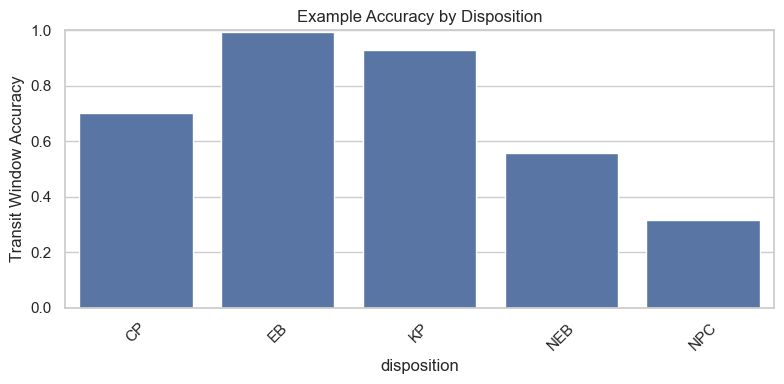


=== TCE-Averaged Example Accuracy by Disposition ===
  disposition  TCE-Level Transit Window Accuracy
0          CP                              0.946
1          EB                              0.997
2          KP                              0.978
3         NEB                              0.295
4         NPC                              0.120


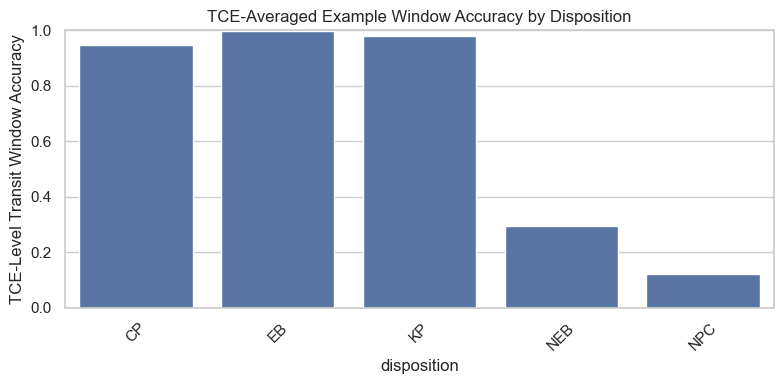

In [ ]:
# def evaluate_transit_window_accuracy(df, threshold=0.5):
#     """
#     For examples where tw_flag == 1, calculate accuracy per disposition.
#     Accuracy here is % of examples where predicted label matches actual label.
#     """
#     tw_df = df[df['tw_flag'] == 1].copy()
#     tw_df['correct'] = (tw_df['pred_label'] == tw_df['label']).astype(int)

#     results = (
#         tw_df.groupby('disposition')['correct']
#         .mean()
#         .reset_index()
#         .rename(columns={'correct': 'Transit Window Accuracy'})
#     )
 
#     print("\n=== Example Accuracy by Disposition ===")
#     print(results.round(3))
    
#     plt.figure(figsize=(8, 4))
#     sns.barplot(data=results, x='disposition', y='Transit Window Accuracy')
#     plt.title("Example Accuracy by Disposition")
#     plt.ylim(0, 1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()
    
#     return results
# def evaluate_tce_level_tw_accuracy(df, threshold=0.5):
#     """
#     For examples where tw_flag == 1, calculate TCE-level accuracy per disposition.
#     - Average pred_prob across all examples per tce_uid
#     - Apply threshold to get TCE-level prediction
#     - Compare to true transit (tw_flag=1) label
#     """
#     # Filter for only examples within transit window
#     tw_df = df[df['tw_flag'] == 1].copy()
    
#     # For each tce, get true label (should always be 1 for tw_flag filtered set)
#     # and average predicted probability
#     tce_avg = (
#         tw_df.groupby(['tce_uid', 'disposition'])
#         .agg(
#             true_label=('label', 'first'),   # will be 1
#             pred_prob_mean=('pred_prob', 'mean')
#         )
#         .reset_index()
#     )
    
#     # Assign predicted label based on threshold
#     tce_avg['pred_label'] = (tce_avg['pred_prob_mean'] >= threshold).astype(int)
    
#     # Accuracy = % where pred_label matches true_label (which should be 1)
#     tce_avg['correct'] = (tce_avg['pred_label'] == tce_avg['true_label']).astype(int)
    
#     # Group by disposition to calculate accuracy
#     results = (
#         tce_avg.groupby('disposition')['correct']
#         .mean()
#         .reset_index()
#         .rename(columns={'correct': 'TCE-Level Transit Window Accuracy'})
#     )
    
#     print("\n=== TCE-Averaged Example Accuracy by Disposition ===")
#     print(results.round(3))
    
#     # Plot
#     plt.figure(figsize=(8, 4))
#     sns.barplot(data=results, x='disposition', y='TCE-Level Transit Window Accuracy')
#     plt.title("TCE-Averaged Example Window Accuracy by Disposition")
#     plt.ylim(0, 1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()
    
#     return results


# tw_accuracy_results = evaluate_transit_window_accuracy(all_preds_tbl)
# tce_tw_accuracy_results = evaluate_tce_level_tw_accuracy(all_preds_tbl)



In [ ]:
# === Inspect number of examples per TCE ===
tce_counts = all_preds_tbl[tce_key].value_counts()


# === Print percentiles to guide cap selection ===
print("Percentiles of example count per TCE:")
print(tce_counts.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).round(2))

# === Optional: show TCEs above a candidate cap ===
candidate_cap = 25
num_above_cap = (tce_counts > candidate_cap).sum()
total_tces = len(tce_counts)
print(f"TCEs above cap of {candidate_cap}: {num_above_cap} / {total_tces} ({num_above_cap / total_tces:.1%})")


In [ ]:

def plot_tce_example_histogram(all_preds_tbl, tce_col='tce_uid', bins=20, title=None):
    """
    Plots a histogram of the number of examples per TCE.

    Parameters:
    - all_preds_tbl: DataFrame containing at least the tce_col.
    - tce_col: Column name representing TCE IDs (default 'tce_id').
    - bins: Number of bins or binning strategy for histogram (default 20).
    - title: Optional plot title.
    """
    # Count examples per TCE
    tce_counts = all_preds_tbl[tce_col].value_counts()

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(tce_counts, bins=bins, edgecolor='black')
    plt.xlabel('Number of examples per TCE')
    plt.ylabel('Number of TCEs')
    plt.title(title or 'Distribution of Examples per TCE')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_tce_example_histogram(all_preds_tbl, bins=1000)


# IMPORTANT ONE

In [42]:

scores_tbl_map = {}

for preds_tbl_name, scores_tbls_dir in {
    "no_ntp_unbal_eb" : "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_no_ntp_low_lr",
    "no_ntp_bal_eb" : "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_no_ntp_bal_eb_ic_low_lr",
    # "ntp_unbal_eb" : "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_bal_ntp_low_lr", 
    "ntp_bal_eb" : "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_bal_ntp_bal_eb_ic_low_lr"
}.items():
    all_preds_tbl = []
    scores_tbls_dir = Path(scores_tbls_dir)
    for split_name in ['train', 'val', 'test']:
        preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
        preds_tbl = pd.read_csv(preds_tbl_fp)
        # Extract identifiers and flags
        preds_tbl['tce_uid'] = preds_tbl['uid'].str.split('_').str[0]
        preds_tbl['target_id'] = preds_tbl['tce_uid'].str.split('-').str[0].astype(int)
        preds_tbl['confusion'] = preds_tbl.apply(_get_confusion_label, axis=1)
        preds_tbl['mixed_target_flag'] = preds_tbl['target_id'].apply(lambda t: 1 if t in mixed_targets else 0)

        # merge_cols = ['tce_uid'] + feature_cols
        # preds_tbl = preds_tbl.merge(
        #     tce_tbl[merge_cols],
        #     on="tce_uid",
        #     how="left",
        #     validate="many_to_one",
        # )

        preds_tbl['split'] = split_name
        all_preds_tbl.append(preds_tbl)
    all_preds_tbl = pd.concat(all_preds_tbl)
    scores_tbl_map[preds_tbl_name] = all_preds_tbl

In [ ]:

# scores_tbls_dir = Path(
#     "/Users/jochoa4/Desktop/pfe_transfers/experiments_08-04-2025/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_no_ntp_bal_eb_ic_low_lr"
# )

# all_preds_tbl = []
# for split_name in ['train', 'val', 'test']:
#     preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
#     preds_tbl = pd.read_csv(preds_tbl_fp)
#      # Extract identifiers and flags
#     preds_tbl['tce_uid'] = preds_tbl['uid'].str.split('_').str[0]
#     preds_tbl['target_id'] = preds_tbl['tce_uid'].str.split('-').str[0].astype(int)
#     preds_tbl['confusion'] = preds_tbl.apply(_get_confusion_label, axis=1)
#     preds_tbl['mixed_target_flag'] = preds_tbl['target_id'].apply(lambda t: 1 if t in mixed_targets else 0)

#     # merge_cols = ['tce_uid'] + feature_cols
#     # preds_tbl = preds_tbl.merge(
#     #     tce_tbl[merge_cols],
#     #     on="tce_uid",
#     #     how="left",
#     #     validate="many_to_one",
#     # )

#     preds_tbl['split'] = split_name
#     all_preds_tbl.append(preds_tbl)
# all_preds_tbl = pd.concat(all_preds_tbl)

# all_preds_tbl.head()



In [47]:
def evaluate_transit_window_accuracy(df, threshold=0.5, show_plot=True, dataset_title=""):
    """
    For examples where tw_flag == 1, calculate accuracy and count per disposition.
    Adds a 'NEG' bar for accuracy and count of all negative examples (label == 0).
    """
    # Transit windows
    tw_df = df[df['tw_flag'] == 1].copy()
    tw_df['correct'] = (tw_df['pred_label'] == tw_df['label']).astype(int)

    # Accuracy and count per disposition
    results = (
        tw_df.groupby('disposition')
        .agg(
            Transit_Window_Accuracy=('correct', 'mean'),
            count=('correct', 'size')
        )
        .reset_index()
    )

    # NEG group: accuracy and count across all label==0 examples
    neg_df = df[df['tw_flag'] == 0].copy()
    neg_df['correct'] = (neg_df['pred_label'] == neg_df['label']).astype(int)
    neg_accuracy = neg_df['correct'].mean()
    neg_count = len(neg_df)

    # Add NEG row
    neg_row = pd.DataFrame([{
        'disposition': 'NEG',
        'Transit_Window_Accuracy': neg_accuracy,
        'count': neg_count
    }])
    results = pd.concat([results, neg_row], ignore_index=True)

    # Print and plot
    print(f"\n=== {dataset_title} Example Accuracy by Disposition (incl. NEG) ===")
    print(results.round(3).to_string(index=False))

    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='Transit_Window_Accuracy')
    plt.title(f"{dataset_title} Example Accuracy by Disposition")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.close()

    return results


def evaluate_tce_level_tw_accuracy(df, threshold=0.5, show_plot=True, dataset_title=""):
    """
    For examples where tw_flag == 1, calculate TCE-level accuracy and count per disposition.
    Adds a 'NEG' bar for accuracy and count of all negative examples (label == 0).
    """
    # Transit window examples
    tw_df = df[df['tw_flag'] == 1].copy()

    tce_avg = (
        tw_df.groupby(['tce_uid', 'disposition'])
        .agg(
            true_label=('label', 'first'),
            pred_prob_mean=('pred_prob', 'mean')
        )
        .reset_index()
    )
    tce_avg['pred_label'] = (tce_avg['pred_prob_mean'] >= threshold).astype(int)
    tce_avg['correct'] = (tce_avg['pred_label'] == tce_avg['true_label']).astype(int)

    # Accuracy and count per disposition
    results = (
        tce_avg.groupby('disposition')
        .agg(
            TCE_Level_Transit_Window_Accuracy=('correct', 'mean'),
            count=('correct', 'size')
        )
        .reset_index()
    )

    # NEG group: TCE-level accuracy and count
    neg_df = df[df['tw_flag'] == 0].copy()
    tce_neg = (
        neg_df.groupby('tce_uid')
        .agg(
            true_label=('label', 'first'),
            pred_prob_mean=('pred_prob', 'mean')
        )
        .reset_index()
    )
    tce_neg['pred_label'] = (tce_neg['pred_prob_mean'] >= threshold).astype(int)
    tce_neg['correct'] = (tce_neg['pred_label'] == tce_neg['true_label']).astype(int)
    neg_accuracy = tce_neg['correct'].mean()
    neg_count = len(tce_neg)

    # Add NEG row
    neg_row = pd.DataFrame([{
        'disposition': 'NEG',
        'TCE_Level_Transit_Window_Accuracy': neg_accuracy,
        'count': neg_count
    }])
    results = pd.concat([results, neg_row], ignore_index=True)

    # Print and plot
    print(f"\n=== {dataset_title} TCE-Averaged Example Accuracy by Disposition (+ NEG) ===")
    print(results.round(3).to_string(index=False))

    plt.figure(figsize=(8, 4))
    sns.barplot(data=results, x='disposition', y='TCE_Level_Transit_Window_Accuracy')
    plt.title(f"{dataset_title} TCE-Averaged Example Accuracy by Disposition ")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.close()

    return results

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, average_precision_score

label_key = 'tw_flag'
tce_key = 'tce_uid'

title_map = {
    0: 'Non Transit',
    1: 'Transit'
}
# === Utility Functions ===
def compute_metrics(df, label_key, score_key, pred_key):
    y_true = df[label_key]
    y_score = df[score_key]
    y_pred = df[pred_key]
    return {
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'PRAUC': average_precision_score(y_true, y_score)
    }

def summarize_by_disposition(df, label_key, score_key, pred_key):
    metrics = []
    for disp, group in df.groupby('disposition'):
        met = compute_metrics(group, label_key, score_key, pred_key)
        met['disposition'] = disp
        metrics.append(met)
    return pd.DataFrame(metrics).set_index('disposition')

def print_metrics(title, metrics_dict):
    print(title)
    s = pd.Series(metrics_dict)
    print(s.round(3))
    print()

def print_disp_metrics(title, metrics_df):
    print(title)
    print(metrics_df.round(3))
    print()

def plot_disp_metrics(metrics_df, title):
    metrics_melted = metrics_df.reset_index().melt(id_vars='disposition', var_name='Metric', value_name='Value')
    plt.figure(figsize=(8, 4))
    sns.barplot(data=metrics_melted, x='disposition', y='Value', hue='Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Unbalanced Dataset

# Balanced Dataset

In [ ]:
show_plots = False
splits = ['test']
no_ntp_unbal_eb_results = evaluate_transit_window_accuracy(scores_tbl_map["no_ntp_unbal_eb"][scores_tbl_map["no_ntp_unbal_eb"]['split'].isin(splits)], show_plot=show_plots, dataset_title="Unbalanced EB - No NTP Dataset")
no_ntp_bal_eb_results = evaluate_transit_window_accuracy(scores_tbl_map["no_ntp_bal_eb"][scores_tbl_map["no_ntp_bal_eb"]['split'].isin(splits)], show_plot=show_plots, dataset_title="Balanced EB - No NTP Dataset")
# ntp_unbal_eb_results = evaluate_transit_window_accuracy(scores_tbl_map["ntp_unbal_eb"][scores_tbl_map["ntp_unbal_eb"]['split'].isin(splits)], show_plot=False)
ntp_bal_eb_results = evaluate_transit_window_accuracy(scores_tbl_map["ntp_bal_eb"][scores_tbl_map["ntp_bal_eb"]['split'].isin(splits)], show_plot=show_plots, dataset_title="Balanced EB - Balanced NTP Dataset")



=== Unbalanced EB - No NTP Dataset Example Accuracy by Disposition (incl. NEG) ===
disposition  Transit_Window_Accuracy  count
         CP                    0.258   8771
         EB                    0.992  35657
         KP                    0.843   2547
        NEB                    0.924   1349
        NPC                    0.764    123
        NEG                    0.995   3602

=== Balanced EB - No NTP Dataset Example Accuracy by Disposition (incl. NEG) ===
disposition  Transit_Window_Accuracy  count
         CP                    0.645   8771
         EB                    0.995   2394
         KP                    0.947   2547
        NEB                    0.439   1349
        NPC                    0.325    123
        NEG                    0.899   3602

=== Balanced EB - Balanced NTP Dataset Example Accuracy by Disposition (incl. NEG) ===
disposition  Transit_Window_Accuracy  count
         CP                    0.617   8771
         EB                    0.965   239

['NEB' 'KP' 'NPC' 'CP' 'EB']
